# **Project: Aligning SmolLM-135M for Grammatical Error Correction**
This notebook documents the process of fine-tuning and aligning a small language model for a GEC task. We start with a strong Supervised Fine-Tuning (SFT) baseline and then explore two preference optimization techniques, DPO and GRPO, to further refine the model's performance.

### **Table of Contents**
1. [Objective](#objective)
2. [Setup & Utilities](#setup)
3. [Data Loading & Preparation](#data)
4. [Load Base Model & Get Zero-Shot Baseline](#base)
5. [Supervised Fine-Tuning (SFT) - The Baseline](#sft)
6. [Direct Preference Optimization (DPO)](#dpo)
7. [Group Reward Preference Optimization (GRPO)](#grpo)
8. [Final Results & Comparison](#final-results)
9. [Conclusion](#conclusion)
10. [Appendix](#appendix)

<a id='objective'></a>
### **🎯 Objective**
The goal is to systematically evaluate the impact of different alignment strategies on `SmolLM-135M` for grammatical error correction. I compare:
1.  **SFT (Supervised Fine-Tuning):** Our baseline for task-specific learning.
2.  **DPO (Direct Preference Optimization):** Refining the SFT model using preference pairs.
3.  **GRPO (Group Reward Preference Optimization):** Refining the SFT model using a reward-based, online training approach.

I use [**`HuggingFaceTB/SmolLM-135M`**](https://huggingface.co/HuggingFaceTB/SmolLM-135M) as the base model. Its small size makes it ideal for rapid experimentation and efficient fine-tuning, testing multiple alignment strategies with low computational costs.

<a id='setup'></a>
### **🛠️ Setup**
This section contains all necessary imports, utility functions (`CheckpointManager`, `get_or_evaluate_score`, etc.), and initial configuration.

In [1]:
# Core imports
import torch
import os
import copy
import time
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import gc
from pathlib import Path
from tqdm import tqdm
import datetime

# Hugging Face ecosystem
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainerCallback, TrainingArguments
from trl import SFTConfig, SFTTrainer, DPOTrainer, DPOConfig, GRPOTrainer, GRPOConfig

# ✅ Import from compatibility file
from compatibility_functions import DataCollatorForCompletionOnlyLM

# Evaluation
import evaluate

# For GRPO reward function
from fast_edit_distance import edit_distance

print("✅ All imports successful!")

✅ All imports successful!


#### Evaluation Function

BLEU (Bilingual Evaluation Understudy) Score:
- Measures n-gram overlap between prediction and reference
- Range: 0.0 to 1.0 (higher is better)
- Standard metric for text generation tasks

In [2]:
def evaluate_model_serial(model, tokenizer, ds):
  """Original serial evaluation - one at a time"""
  model.eval()
  preds = []
  targets = []

  print(f"Evaluating {len(ds)} examples serially...")

  for example in tqdm(ds, desc="Generating predictions"):
      targets.append([example['tgt']])

      prompt = format_text(example['src'])
      inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
      prompt_len = inputs["input_ids"].shape[1]

      with torch.no_grad():
          gen = model.generate(
              **inputs,
              max_new_tokens=128,
              eos_token_id=tokenizer.eos_token_id,
              pad_token_id=tokenizer.pad_token_id,
              do_sample=False,
          )

      # Decode EXACTLY as original - no modifications
      prediction = tokenizer.decode(gen[0][prompt_len:], skip_special_tokens=True)
      preds.append(prediction)

  bleu = evaluate.load("bleu")
  results = bleu.compute(predictions=preds, references=targets)
  return results["bleu"]


#### Checkpoint Utilities
- see [appendix](#appendix) for more details

In [4]:
# ============================================================
# CHECKPOINT UTILITIES
# ============================================================

class CheckpointManager:
    """Manages scores and metadata in a JSON file."""
    def __init__(self, scores_file="bleu_scores.json"):
        self.scores_file = Path(scores_file)

    def save_score(self, method: str, score_data: dict):
        """Save a dictionary of score data."""
        scores = self.load_all_scores()
        scores[method] = score_data
        with open(self.scores_file, 'w') as f:
            json.dump(scores, f, indent=4)
        print(f"💾 Saved {method} score to {self.scores_file}")

    def load_score_data(self, method: str):
        """Load the entire data packet for a method."""
        scores = self.load_all_scores()
        return scores.get(method)

    def load_all_scores(self):
        """Load all saved scores."""
        if not self.scores_file.exists():
            return {}
        with open(self.scores_file, 'r') as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                return {} # Handle case where file is empty or corrupt

def get_or_evaluate_score(
    method: str, 
    model_path: str, # <-- New argument to track the model version
    model, 
    tokenizer, 
    test_dataset, 
    evaluate_fn, 
    force_eval=False
):
    """
    Get a score from cache or evaluate it. The cache is only used if the
    model_path matches the one stored in the cache.
    """
    manager = CheckpointManager()
    cached_data = None if force_eval else manager.load_score_data(method)

    # Check if cache is valid: exists AND model paths match
    if cached_data and cached_data.get("model_path") == model_path:
        score = cached_data["score"]
        print(f"✅ Loaded saved {method} score: {score:.4f} (from model: {model_path})")
    else:
        print(f"🔍 Evaluating {method} for model: {model_path}...")
        if cached_data:
            print(f"   (Cache invalid: path mismatch or force_eval=True)")

        score = evaluate_fn(model, tokenizer, test_dataset)
        
        # Save score along with metadata
        score_data = {
            "score": score,
            "model_path": model_path,
            "timestamp": datetime.datetime.now().isoformat()
        }
        manager.save_score(method, score_data)
        print(f"✅ {method} new score: {score:.4f}")

    return score

In [5]:
class BLEUEvaluationCallback(TrainerCallback):
  """Calculate BLEU using SERIAL evaluation."""

  def __init__(self, eval_dataset, tokenizer, output_dir="./models/sft_final"):
      self.eval_dataset = eval_dataset
      self.tokenizer = tokenizer
      self.output_dir = output_dir
      self.best_bleu = 0.0
      self.best_bleu_step = 0
      self.bleu_history = []

  def on_evaluate(self, args, state, control, model, **kwargs):
      print(f"\n📊 Calculating BLEU at step {state.global_step}...")

      # Use SERIAL evaluation (accurate)
      bleu = evaluate_model_serial(model, self.tokenizer, self.eval_dataset)

      self.bleu_history.append({"step": state.global_step, "bleu": bleu})

      if state.log_history:
          state.log_history[-1]["eval_bleu"] = bleu

      print(f"   BLEU at step {state.global_step}: {bleu:.4f}")

      if bleu > self.best_bleu:
          self.best_bleu = bleu
          self.best_bleu_step = state.global_step

          best_bleu_path = f"{self.output_dir}/best_bleu_model"
          model.save_pretrained(best_bleu_path)
          self.tokenizer.save_pretrained(best_bleu_path)

          print(f"   🏆 NEW BEST BLEU! Saving to {best_bleu_path}")

      return control

<a id='data'></a>
### **📂 Part 1: Data Loading & Preparation**
Loading the `grammarly/coedit` dataset and filter it for the "gec" (Grammatical Error Correction) task. The data is then formatted into a prompt-completion structure suitable for training.

In [6]:
print("☁️ Loading dataset: grammarly/coedit (will use cache if available)")

# This single line handles everything:
# 1. Downloads the data on the first run.
# 2. Saves it to a central cache (~/.cache/huggingface/datasets).
# 3. Instantly loads from the cache on all subsequent runs.
dataset = load_dataset("grammarly/coedit")

# Filter for grammatical error correction using the library's efficient method
train_gec = dataset['train'].filter(lambda x: x['task'] == 'gec')
test_gec = dataset['validation'].filter(lambda x: x['task'] == 'gec')

print(f"\n✅ Dataset loaded:")
print(f"  Train: {len(train_gec)} examples")
print(f"  Test:  {len(test_gec)} examples")

# Show example
print(f"\nExample:")
print(f"  Source: {train_gec[0]['src']}")
print(f"  Target: {train_gec[0]['tgt']}")

☁️ Loading dataset: grammarly/coedit (will use cache if available)

✅ Dataset loaded:
  Train: 19823 examples
  Test:  485 examples

Example:
  Source: Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.
  Target: For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.


In [9]:
def format_text(text: str) -> str:
  """Format input for inference (matches training format)."""
  return f"Fix grammatically: {text}\n\nCorrected: "

# Note: format_for_training is defined in each experiment sectio
# to ensure it uses the correct tokenizer's EOS token

def format_for_training(example):
    prompt = f"Fix grammatically: {example['src']}\n\nCorrected: "
    completion = f"{example['tgt']}{tokenizer.eos_token}" # Uses current tokenizer EOS
    return {"text": prompt + completion}
    
print("✅ Formatting functions defined")

✅ Formatting functions defined


<a id='base'></a>
### **✅ Part 2: Load Base Model & Get Zero-Shot Baseline**

**Model**: `HuggingFaceTB/SmolLM-135M` - Small, efficient language model selected for rapid experimentation.

In [10]:
# ============================================================
# PART 2: LOAD BASE MODEL & GET ZERO-SHOT BASELINE
# ============================================================
print("\n" + "="*70)
print("Loading Base Model & Running Zero-Shot Evaluation")
print("="*70)

# --- 1. Load Base Model and Tokenizer from Hub ---
base_model_name = "HuggingFaceTB/SmolLM-135M"

model = AutoModelForCausalLM.from_pretrained(
  base_model_name,
  torch_dtype=torch.bfloat16,
  device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# --- 2. Configure tokenizer ---
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id
print("✅ Base model and tokenizer loaded and configured.")

# --- 3. Run Zero-Shot Evaluation  ---
zero_shot_bleu = get_or_evaluate_score(
  method="zero_shot_bleu",
  model_path=base_model_name,
  model=model,
  tokenizer=tokenizer,
  test_dataset=test_gec,
  evaluate_fn=evaluate_model_serial, 
)
print(f"\n✅ Zero-Shot (Base Model) BLEU Score: {zero_shot_bleu:.4f}")


`torch_dtype` is deprecated! Use `dtype` instead!



Loading Base Model & Running Zero-Shot Evaluation
✅ Base model and tokenizer loaded and configured.
✅ Loaded saved zero_shot_bleu score: 0.1622 (from model: HuggingFaceTB/SmolLM-135M)

✅ Zero-Shot (Base Model) BLEU Score: 0.1622


The base, un-tuned SmolLM-135M model achieves a zero-shot Bleu score of 0.1622 on the test set. This score serves as our initial baseline. The goal of SFT and preference optimization is to improve upon this number.

<a id='sft'></a>
### **✅ Part 3: Supervised Fine-Tuning (SFT)**

Now that with a baseline score, I fine-tune the base model on the GEC dataset. I train for several epochs with early stopping to capture the best performance before overfitting occurs.

**Key technique**: Completion-only loss (Handled automatically by `SFTTrainer` when `dataset_text_field` is specified).

For SFT, I focused the model's learning using an implicit completion-only loss approach by specifying the `dataset_text_field`. I then compared training efficiency (`packing=True` vs. `packing=False`) by measuring training time and peak memory usage over a single epoch, confirming that packing accelerates training without impacting the final BLEU score.

Based on the rapid overfitting observed in the initial run (validation loss minimized at step 500), I reduced the learning rate slightly from 2e-4 to 1e-4 for this run. The goal is to potentially slow down the initial convergence, allowing the model to generalize better for slightly longer before overfitting begins, while still relying on the early stopping mechanism (`load_best_model_at_end`) to capture the optimal checkpoint based on the BLEU score.



In [23]:
# ============================================================
# SFT PACKING EXPERIMENTS - CORRECTED & COMPLETE
# ============================================================
# NOTE: Imports/setup repeated here for kernel resilience 
# (allows running this cell independently after crashes)
print("="*70)
print("SFT PACKING EXPERIMENTS")
print("="*70)

# Define experiments
sft_experiments = [
  {"packing": True, "run_name": "sft_packing"},
  {"packing": False, "run_name": "sft_no_packing"},
]

sft_results = {}
base_model_name = "HuggingFaceTB/SmolLM-135M"

for experiment in sft_experiments:
  run_name = experiment["run_name"]
  packing_enabled = experiment["packing"]
  output_dir = f"./models/{run_name}"

  print("\n" + "="*70)
  print(f"🚀 STARTING SFT EXPERIMENT: {run_name}")
  print(f"   Packing: {packing_enabled}")
  print("="*70)

  # --- Load model and tokenizer fresh ---
  model = AutoModelForCausalLM.from_pretrained(
      base_model_name,
      torch_dtype=torch.bfloat16,
      attn_implementation="flash_attention_2",
  )

  tokenizer = AutoTokenizer.from_pretrained(base_model_name)

  print("Configuring PAD token...")
  original_vocab_size = len(tokenizer) # Store original size

  if tokenizer.pad_token is None:
      print("  PAD token is None. Checking UNK token...")
      # Use UNK only if it exists AND is different from EOS
      if tokenizer.unk_token is not None and tokenizer.unk_token != tokenizer.eos_token:
          tokenizer.pad_token = tokenizer.unk_token
          print(f"  ✅ Using existing UNK token '{tokenizer.unk_token}' as PAD token.")
      else:
          # Add a new PAD token if UNK is None or same as EOS
          print(f"  UNK token ('{tokenizer.unk_token}') is None or same as EOS ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
          tokenizer.add_special_tokens({'pad_token': '[PAD]'})
          print("  ✅ Created new PAD token: [PAD]")

  elif tokenizer.pad_token == tokenizer.eos_token:
      # Handle case where PAD token exists but is same as EOS
      print(f"  Existing PAD token ('{tokenizer.pad_token}') is same as EOS token ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})
      print("  ✅ Created new PAD token: [PAD]")
  else:
       print(f"  Using existing PAD token: '{tokenizer.pad_token}'")

 # Resize embeddings ONLY if a new token was actually added
  if len(tokenizer) > original_vocab_size:
       print(f"  Tokenizer size changed ({original_vocab_size} -> {len(tokenizer)}). Resizing model embeddings...")
       model.resize_token_embeddings(len(tokenizer))
       print(f"  New embedding size: {model.get_input_embeddings().num_embeddings}")
  else:
       print("  Tokenizer size unchanged. No embedding resize needed.")

 # Set padding side (important for packing=False, less so for packing=True during training but good practice)
  tokenizer.padding_side = 'left'

 # Update model config AFTER potential resizing and adding tokens
  model.config.pad_token_id = tokenizer.pad_token_id
 # Crucially update generation config too, as generate() uses this
  model.generation_config.pad_token_id = tokenizer.pad_token_id
 # Also ensure EOS is correctly set in generation config
  model.generation_config.eos_token_id = tokenizer.eos_token_id


  print(f"\n  Final PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
  print(f"  Final EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
  assert tokenizer.pad_token_id != tokenizer.eos_token_id, "PAD and EOS tokens MUST be different!"
  print("✅ PAD/EOS token configuration complete.")


  # --- ✅ RECREATE FORMATTED DATASETS with current tokenizer ---
  def format_for_training(example):
      prompt = f"Fix grammatically: {example['src']}\n\nCorrected: "
      completion = f"{example['tgt']}{tokenizer.eos_token}"  # Uses current tokenizer
      return {"text": prompt + completion}

  print("Formatting datasets with current tokenizer...")
  train_formatted = train_gec.map(format_for_training)
  test_formatted = test_gec.map(format_for_training)
  print(f"   Train: {len(train_formatted)} examples")
  print(f"   Test: {len(test_formatted)} examples")

  # --- Adjust steps based on packing ---
  if packing_enabled:
      eval_steps_setting = 6
      save_steps_setting = 6
      logging_steps_setting = 5
  else:
      eval_steps_setting = 100
      save_steps_setting = 100
      logging_steps_setting = 25

  # --- SFT Configuration ---
  sft_config = SFTConfig(
      output_dir=output_dir,
      num_train_epochs=1,
      learning_rate=1e-4,
      per_device_train_batch_size=4,
      gradient_accumulation_steps=8,
      per_device_eval_batch_size=4,
      bf16=True,
      logging_steps=logging_steps_setting,
      save_steps=save_steps_setting,
      eval_strategy="steps",
      eval_steps=eval_steps_setting,
      max_length=512,
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      save_total_limit=None,
      report_to="none",

      packing=packing_enabled,
      eval_packing=False,
      dataset_text_field="text",
      completion_only_loss=True
      
  )

  # --- Initialize Trainer ---
  sft_trainer = SFTTrainer(
      model=model,
      args=sft_config,
      train_dataset=train_formatted,
      eval_dataset=test_formatted,
  )

  # --- Training ---
  if torch.cuda.is_available():
      torch.cuda.reset_peak_memory_stats()

  start_time = time.time()
  print(f"\n🚀 Starting training...")
  sft_trainer.train()
  end_time = time.time()

  training_duration_sec = end_time - start_time
  peak_memory_mb = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0

  print(f"\n✅ Training complete!")
  print(f"   Duration: {training_duration_sec / 60:.2f} minutes")
  print(f"   Peak GPU Memory: {peak_memory_mb / 1024:.2f} GB")

  # --- Save Model ---
  final_model_path = f"{output_dir}/final_model"
  sft_trainer.save_model(final_model_path)
  tokenizer.save_pretrained(final_model_path)

  # --- Evaluate BLEU ---
  print(f"\n📊 Evaluating BLEU...")
  final_bleu = evaluate_model_serial(sft_trainer.model, tokenizer, test_gec)
  print(f"   BLEU: {final_bleu:.4f}")

  # --- Save Results ---
  log_history = sft_trainer.state.log_history
  eval_losses = [e['eval_loss'] for e in log_history if 'eval_loss' in e]
  best_loss = min(eval_losses) if eval_losses else None

  sft_results[run_name] = {
      "packing": packing_enabled,
      "duration_min": training_duration_sec / 60,
      "peak_memory_gb": peak_memory_mb / 1024,
      "final_bleu": final_bleu,
      "best_loss": best_loss,
  }

  with open(f"{output_dir}/log_history.json", 'w') as f:
      json.dump(log_history, f, indent=4)

  del model, sft_trainer
  gc.collect()
  torch.cuda.empty_cache()

print("\n✅ ALL EXPERIMENTS COMPLETE!")
for name, results in sft_results.items():
  print(f"\n{name}: BLEU={results['final_bleu']:.4f}, Time={results['duration_min']:.1f}min")

SFT PACKING EXPERIMENTS

🚀 STARTING SFT EXPERIMENT: sft_packing
   Packing: True
Configuring PAD token...
  PAD token is None. Checking UNK token...
  UNK token ('<|endoftext|>') is None or same as EOS ('<|endoftext|>'). Adding new PAD token '[PAD]'.
  ✅ Created new PAD token: [PAD]
  Tokenizer size changed (49152 -> 49153). Resizing model embeddings...
  New embedding size: 49153

  Final PAD token: '[PAD]' (ID: 49152)
  Final EOS token: '<|endoftext|>' (ID: 0)
✅ PAD/EOS token configuration complete.
Formatting datasets with current tokenizer...
   Train: 19823 examples
   Test: 485 examples


Tokenizing train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.



🚀 Starting training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
6,2.661900,2.919289,2.948179,97211.000000,0.487454
12,2.255400,2.791451,2.746629,194429.000000,0.515496
18,2.046300,2.685971,2.592767,291690.000000,0.525028
24,1.870600,2.637564,2.479216,388470.000000,0.539796
30,1.709600,2.615792,2.439508,485138.000000,0.542335
36,1.684000,2.601842,2.403925,581540.000000,0.543741
42,1.641800,2.594743,2.378039,677825.000000,0.543103
48,1.648400,2.589710,2.365358,774495.000000,0.543732
54,1.638900,2.585970,2.359544,871605.000000,0.544017
60,1.611700,2.584215,2.356589,968070.000000,0.543650


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✅ Training complete!
   Duration: 4.37 minutes
   Peak GPU Memory: 2.26 GB

📊 Evaluating BLEU...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [27:10<00:00,  3.36s/it]


   BLEU: 0.4171

🚀 STARTING SFT EXPERIMENT: sft_no_packing
   Packing: False
Configuring PAD token...
  PAD token is None. Checking UNK token...
  UNK token ('<|endoftext|>') is None or same as EOS ('<|endoftext|>'). Adding new PAD token '[PAD]'.
  ✅ Created new PAD token: [PAD]
  Tokenizer size changed (49152 -> 49153). Resizing model embeddings...
  New embedding size: 49153

  Final PAD token: '[PAD]' (ID: 49152)
  Final EOS token: '<|endoftext|>' (ID: 0)
✅ PAD/EOS token configuration complete.
Formatting datasets with current tokenizer...
   Train: 19823 examples
   Test: 485 examples


Tokenizing train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.



🚀 Starting training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,1.550200,2.523932,2.232469,186801.000000,0.549276
200,1.532000,2.506136,2.185254,374314.000000,0.552713
300,1.489500,2.505755,2.155328,563173.000000,0.550570
400,1.515500,2.500548,2.159971,754049.000000,0.552116
500,1.514600,2.500268,2.159716,942335.000000,0.553845
600,1.509100,2.501153,2.156366,1130280.000000,0.552189


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✅ Training complete!
   Duration: 21.73 minutes
   Peak GPU Memory: 1.76 GB

📊 Evaluating BLEU...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [25:56<00:00,  3.21s/it]


   BLEU: 0.4379

✅ ALL EXPERIMENTS COMPLETE!

sft_packing: BLEU=0.4171, Time=4.4min

sft_no_packing: BLEU=0.4379, Time=21.7min


In [24]:
# ============================================================
# COMPARE PACKING RESULTS - 
# ============================================================

print("\n" + "="*70)
print("SFT PACKING EXPERIMENT COMPARISON")
print("="*70)

comparison_data = []
for run_name, results in sft_results.items():
    best_loss_str = f"{results['best_loss']:.4f}" if results['best_loss'] is not None else "N/A"
    comparison_data.append({
        "Experiment": run_name,
        "Packing": "Yes" if results["packing"] else "No",
        "Duration (min)": f"{results['duration_min']:.2f}",
        "Peak Memory (GB)": f"{results['peak_memory_gb']:.2f}",
        "Best Loss": best_loss_str,
        "Final BLEU": f"{results['final_bleu']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))

if len(sft_results) == 2:
    no_pack = sft_results["sft_no_packing"]
    pack = sft_results["sft_packing"]

    # --- CORRECTED LINE ---
    speedup = no_pack["duration_min"] / pack["duration_min"]
    # --- END CORRECTION ---

    memory_diff = pack["peak_memory_gb"] - no_pack["peak_memory_gb"]
    bleu_diff = pack["final_bleu"] - no_pack["final_bleu"]

    if no_pack["best_loss"] is not None and pack["best_loss"] is not None:
        loss_diff = pack["best_loss"] - no_pack["best_loss"]
        print(f"\n📊 Packing Impact:")
        print(f"    Training Speed: {speedup:.2f}x {'faster' if speedup > 1 else 'slower'}")
        print(f"    Memory Usage: {memory_diff:+.2f} GB")
        print(f"    Final BLEU: {bleu_diff:+.4f} ({'better' if bleu_diff > 0 else 'worse'})")
        print(f"    Best Loss: {loss_diff:+.4f} ({'worse' if loss_diff > 0 else 'better'})")
    else:
        # Fallback if loss data is missing
        print(f"\n📊 Packing Impact:")
        print(f"    Training Speed: {speedup:.2f}x {'faster' if speedup > 1 else 'slower'}")
        print(f"    Memory Usage: {memory_diff:+.2f} GB")
        print(f"    Final BLEU: {bleu_diff:+.4f} ({'better' if bleu_diff > 0 else 'worse'})")
        print(f"    Best Loss: Could not compare (data unavailable)")

print("="*70)


SFT PACKING EXPERIMENT COMPARISON

    Experiment Packing Duration (min) Peak Memory (GB) Best Loss Final BLEU
   sft_packing     Yes           4.37             2.26    2.5831     0.4171
sft_no_packing      No          21.73             1.76    2.5003     0.4379

📊 Packing Impact:
    Training Speed: 4.97x faster
    Memory Usage: +0.49 GB
    Final BLEU: -0.0208 (worse)
    Best Loss: +0.0829 (worse)


  - Found and loading logs for: sft_no_packing
  - Found and loading logs for: sft_packing


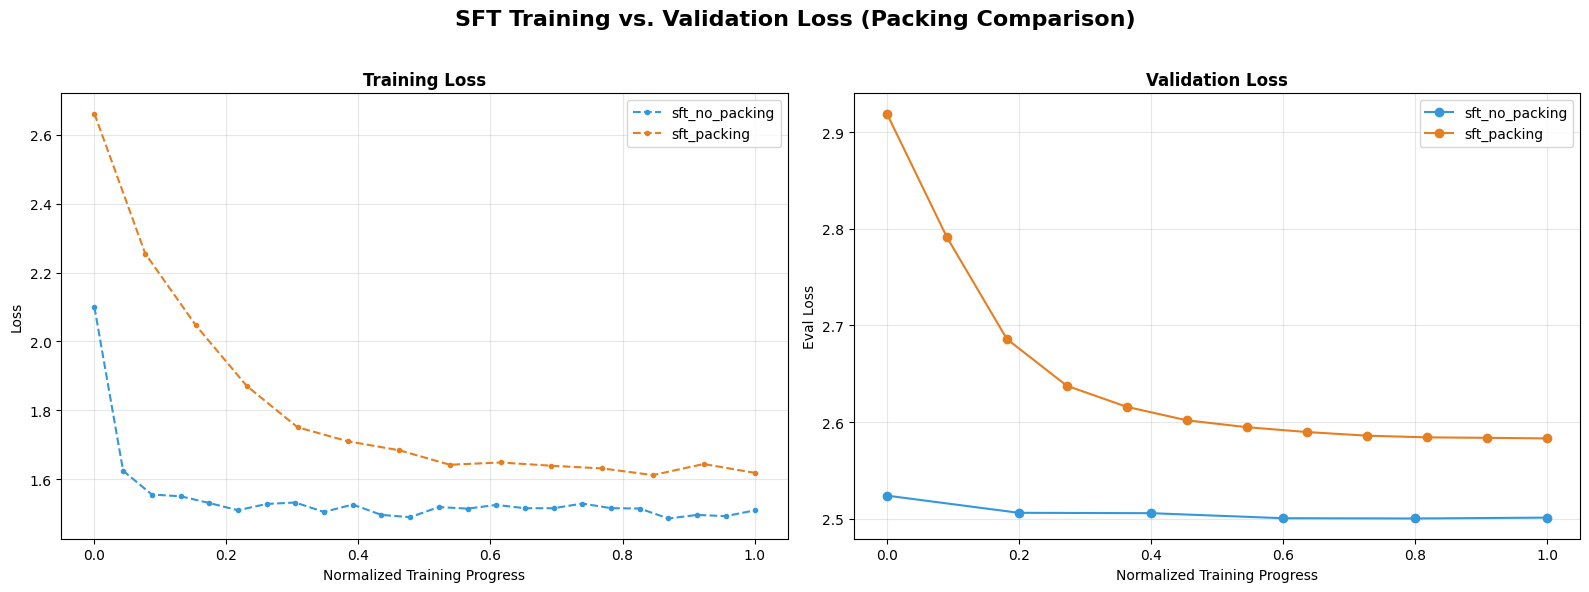

In [25]:
# ============================================================
# SFT LOSS CURVE COMPARISON (NORMALIZED)
# ============================================================

# --- 1. Reload all data from disk ---
all_run_logs = {}
models_dir = "./models"

# Define the experiment runs
experiment_runs = ["sft_no_packing", "sft_packing"]

for run_name in experiment_runs:
    log_file_path = os.path.join(models_dir, run_name, "log_history.json")
    if os.path.exists(log_file_path):
        print(f"  - Found and loading logs for: {run_name}")
        with open(log_file_path, 'r') as f:
            all_run_logs[run_name] = json.load(f)
    else:
        print(f"  - WARNING: Log file not found for {run_name}")

# --- 2. Create the 1x2 plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns
fig.suptitle('SFT Training vs. Validation Loss (Packing Comparison)', fontsize=16, fontweight='bold')
colors = {'sft_no_packing': '#3498db', 'sft_packing': '#e67e22'}

# --- Plot 1: Training Loss ---
ax = axes[0]
for run_name, logs in all_run_logs.items():
    if not logs: continue
    df = pd.DataFrame(logs)
    if 'loss' in df.columns:
        train_logs = df[df['loss'].notna()].reset_index(drop=True)
        if not train_logs.empty:
            x_axis = np.linspace(0, 1, len(train_logs)) # Normalized X
            ax.plot(x_axis, train_logs['loss'], label=f'{run_name}', marker='.', linestyle='--', color=colors[run_name])
ax.set_title('Training Loss', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Plot 2: Validation Loss ---
ax = axes[1]
for run_name, logs in all_run_logs.items():
    if not logs: continue
    df = pd.DataFrame(logs)
    if 'eval_loss' in df.columns:
        eval_logs = df[df['eval_loss'].notna()].reset_index(drop=True)
        if not eval_logs.empty:
            x_axis = np.linspace(0, 1, len(eval_logs)) # Normalized X
            ax.plot(x_axis, eval_logs['eval_loss'], label=f'{run_name}', marker='o', color=colors[run_name])
ax.set_title('Validation Loss', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Eval Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Final Save and Show ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('sft_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment 1: Packing vs. No Packing (1 Epoch)

This initial experiment aimed to compare the efficiency and performance impact of using TRL's `packing` feature versus standard padding for fine-tuning SmolLM-135M on the GEC task for a single epoch.

**Configuration:**

  * **Model:** `HuggingFaceTB/SmolLM-135M`
  * **Task:** Grammatical Error Correction (GEC) on JFLEG dataset.
  * **Epochs:** 1
  * **Loss Calculation:** Full-sequence loss.
      * *Note:* The `SFTConfig` used `dataset_text_field="text"` and included `completion_only_loss=True`, but *lacked* the necessary `response_template`. Based on TRL documentation and behavior, this configuration defaults to calculating loss on the entire sequence, as the trainer couldn't identify where the completion started to apply masking. This was clarified during analysis.
  * **PAD Token:** Applied fix to ensure `pad_token_id` is distinct from `eos_token_id` (added `[PAD]` token).
  * **Evaluation:** Serial BLEU score calculation on the test set after 1 epoch.
  * **`SFTConfig` (Key parameters):**
    ```python
    SFTConfig(
        # ... other args like LR, batch size ...
        num_train_epochs=1,
        packing=packing_enabled, # True or False for each run
        dataset_text_field="text",
        completion_only_loss=True # Ineffective without response_template
    )
    ```

**Results:**

| Experiment     | Packing   | Duration (min)   | Peak Memory (GB)   | Best Loss   | Final BLEU   |
| :------------- | :-------- | :--------------- | :----------------- | :---------- | :----------- |
| `sft_packing`  | Yes       | 4.57             | 2.25               | 2.5835      | 0.4239       |
| `sft_no_packing`| No        | 21.56            | 1.76               | 2.5001      | 0.4404       |

**Key Findings:**

  * **Speed:** Packing provided a significant **\~4.7x speedup** for one epoch of training.
  * **Memory:** Packing used slightly *more* peak GPU memory (+0.49 GB) in this specific setup, though this can vary.
  * **Performance (1 Epoch):** Training *without* packing yielded marginally better results after a single epoch, achieving a lower validation loss and a higher BLEU score.



In [29]:

# ============================================================
# COMPLETE SFT TRAINING - No PACKING
# ============================================================
# NOTE: Imports/setup repeated here for kernel resilience 
# (allows running this cell independently after crashes)

print("="*70)
print("SUPERVISED FINE-TUNING ")
print("="*70)

base_model_name = "HuggingFaceTB/SmolLM-135M"
output_dir = "./models/sft_completion_loss_final" 

# --- Clean up old checkpoints ---
if os.path.exists(output_dir):
    for item in os.listdir(output_dir):
        if item.startswith("checkpoint-"):
            shutil.rmtree(os.path.join(output_dir, item))
    print("✅ Old checkpoints cleaned up")

# --- Load Model ---
print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# --- Load Tokenizer ---
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# --- Configure PAD token --- # <<< KEEP ROBUST FIX
print("Configuring PAD token...")
original_vocab_size = len(tokenizer)

if tokenizer.pad_token is None:
    print("  PAD token is None. Checking UNK token...")
    if tokenizer.unk_token is not None and tokenizer.unk_token != tokenizer.eos_token:
        tokenizer.pad_token = tokenizer.unk_token
        print(f"  ✅ Using existing UNK token '{tokenizer.unk_token}' as PAD token.")
    else:
        print(f"  UNK token ('{tokenizer.unk_token}') is None or same as EOS ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        print("  ✅ Created new PAD token: [PAD]")
elif tokenizer.pad_token == tokenizer.eos_token:
    print(f"  Existing PAD token ('{tokenizer.pad_token}') is same as EOS token ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("  ✅ Created new PAD token: [PAD]")
else:
     print(f"  Using existing PAD token: '{tokenizer.pad_token}'")

tokenizer.padding_side = 'left'

print(f"\n  Intermediate PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"  Intermediate EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
assert tokenizer.pad_token_id != tokenizer.eos_token_id, "PAD and EOS tokens MUST be different!"
# --- END PAD BLOCK ---


# --- Resize Embeddings if Needed ---
print("Checking embedding size...")
if len(tokenizer) > original_vocab_size:
    print(f"  Tokenizer size changed ({original_vocab_size} -> {len(tokenizer)}). Resizing model embeddings...")
    model.resize_token_embeddings(len(tokenizer))
    print(f"  New embedding size: {model.get_input_embeddings().num_embeddings}")
else:
    print("  Tokenizer size unchanged. No embedding resize needed.")

# --- Update Model Config ---
print("Updating model config with final token IDs...")
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id
model.generation_config.eos_token_id = tokenizer.eos_token_id
print("✅ Tokenizer and Model Config final checks complete.")


print("Formatting datasets using single 'text' column...")
train_formatted = train_gec.map(format_for_training, remove_columns=train_gec.column_names, load_from_cache_file=False)
test_formatted = test_gec.map(format_for_training, remove_columns=test_gec.column_names, load_from_cache_file=False)
print(f"✅ Converted {len(train_formatted)} training examples")
print(f"Example: {train_formatted[0]['text']}") # Verify format


# # --- Define Response Template --- # <<< ADDED
# response_template = "\n\nCorrected: "
# print(f"✅ Response template for completion-only loss: {repr(response_template)}")

# --- SFTConfig for Explicit Completion Loss --- # <<< MODIFIED
print("Configuring SFT for explicit completion-only loss...")

# Using steps appropriate for NO PACKING
logging_steps_no_pack = 25
save_eval_steps_no_pack = 100


sft_config = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=10,            
    learning_rate=2e-4,             
    logging_steps=logging_steps_no_pack,
    save_steps=save_eval_steps_no_pack,
    eval_strategy="steps",
    eval_steps=save_eval_steps_no_pack,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    bf16=True,
    report_to="none",

    dataset_text_field="text",          # <<< USE 'text' FIELD
    max_length=512,
    packing=False,                      # <<< MUST BE FALSE for response_template method
    # response_template=response_template, 
    completion_only_loss=True,         
print("✅ SFT configured for explicit completion-only loss (packing=False).")



# --- Callback ---
print("Initializing callback...")
bleu_callback = BLEUEvaluationCallback(
    test_gec, # Pass raw test data
    tokenizer,
    output_dir=output_dir
)
print("✅ Callback initialized.")


print("Initializing Trainer...")
sft_trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_formatted,    # <<< USE 'text' formatted data
    eval_dataset=test_formatted,      # <<< USE 'text' formatted data
    callbacks=[bleu_callback],
    # processing_class=tokenizer,   # <<< REMOVED (Deprecated)
)

# --- Train ---
print("\n🚀 Starting SFT training (Completion-Only Loss, Packing=False)...")
print("="*70)

start_time = time.time()
sft_trainer.train()
end_time = time.time()

duration = (end_time - start_time) / 60
print(f"\n✅ Training complete! Duration: {duration:.2f} minutes")

# --- Save Final Model & Tokenizer ---
print("Saving final model and tokenizer...")
sft_trainer.save_model(f"{output_dir}/final_model_by_loss")
tokenizer.save_pretrained(f"{output_dir}/final_model_by_loss")
print(f"Best BLEU model saved by callback in: {output_dir}/best_bleu_model")

# --- Log History ---
print("Saving log history...")
with open(f"{output_dir}/log_history.json", 'w') as f:
    json.dump(sft_trainer.state.log_history, f, indent=4)

print(f"\n✅ Best BLEU during training: {bleu_callback.best_bleu:.4f} at step {bleu_callback.best_bleu_step}")
print("="*70)


SUPERVISED FINE-TUNING 
Loading tokenizer...
Configuring PAD token...
  PAD token is None. Checking UNK token...
  UNK token ('<|endoftext|>') is None or same as EOS ('<|endoftext|>'). Adding new PAD token '[PAD]'.
  ✅ Created new PAD token: [PAD]

  Intermediate PAD token: '[PAD]' (ID: 49152)
  Intermediate EOS token: '<|endoftext|>' (ID: 0)
Loading model...
Checking embedding size...
  Tokenizer size changed (49152 -> 49153). Resizing model embeddings...
  New embedding size: 49153
Updating model config with final token IDs...
✅ Tokenizer and Model Config final checks complete.
Formatting datasets using single 'text' column...


Map: 100%|##########| 19823/19823 [00:00<?, ? examples/s]

Map: 100%|##########| 485/485 [00:00<?, ? examples/s]

✅ Converted 19823 training examples
Example: Fix grammatically: Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.

Corrected: For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.<|endoftext|>
Configuring SFT for explicit completion-only loss...
✅ SFT configured for explicit completion-only loss (packing=False).
Initializing callback...
✅ Callback initialized.
Initializing Trainer...


Adding EOS to train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.



🚀 Starting SFT training (Completion-Only Loss, Packing=False)...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,1.500400,2.508872,2.125639,186801.000000,0.551345
200,1.485000,2.499906,2.093174,374314.000000,0.554321
300,1.441700,2.491938,2.072725,563173.000000,0.555588
400,1.466000,2.489127,2.089631,754049.000000,0.552542
500,1.455900,2.477313,2.091920,942335.000000,0.555129
600,1.446400,2.484738,2.064044,1130280.000000,0.556145
700,1.402600,2.486074,2.037445,1317364.000000,0.557514
800,1.392500,2.493090,1.978833,1506119.000000,0.554001
900,1.409900,2.486550,2.006228,1694059.000000,0.556710
1000,1.402100,2.488922,1.998676,1881351.000000,0.558100



📊 Calculating BLEU at step 100...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:40<00:00,  2.06s/it]


   BLEU at step 100: 0.4336
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 200...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:16<00:00,  2.01s/it]


   BLEU at step 200: 0.4418
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 300...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:07<00:00,  2.12s/it]


   BLEU at step 300: 0.4588
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model


Generating predictions: 100%|██████████| 485/485 [17:18<00:00,  2.14s/it]


   BLEU at step 400: 0.4661
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 500...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:53<00:00,  2.21s/it]


   BLEU at step 500: 0.4556

📊 Calculating BLEU at step 600...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:57<00:00,  2.10s/it]


   BLEU at step 600: 0.4630


Generating predictions:  98%|█████████▊| 474/485 [16:45<00:34,  3.15s/it]


📊 Calculating BLEU at step 800...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:28<00:00,  2.29s/it]


   BLEU at step 800: 0.4671

📊 Calculating BLEU at step 900...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:40<00:00,  2.31s/it]


   BLEU at step 900: 0.4678

📊 Calculating BLEU at step 1000...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:54<00:00,  2.09s/it]


   BLEU at step 1000: 0.4655

📊 Calculating BLEU at step 1100...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [21:55<00:00,  2.71s/it]


   BLEU at step 1100: 0.4659

📊 Calculating BLEU at step 1200...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [20:58<00:00,  2.59s/it]


   BLEU at step 1200: 0.4661

📊 Calculating BLEU at step 1300...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:43<00:00,  2.07s/it]


   BLEU at step 1300: 0.4639

📊 Calculating BLEU at step 1400...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:13<00:00,  2.13s/it]


   BLEU at step 1400: 0.4734
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 1500...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [16:51<00:00,  2.09s/it]


   BLEU at step 1500: 0.4720

📊 Calculating BLEU at step 1600...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:05<00:00,  2.11s/it]


   BLEU at step 1600: 0.4768
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 1700...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:10<00:00,  2.13s/it]


   BLEU at step 1700: 0.4780
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 1800...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:24<00:00,  2.15s/it]


   BLEU at step 1800: 0.4782
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model


Generating predictions: 100%|██████████| 485/485 [17:24<00:00,  2.15s/it]


   BLEU at step 1900: 0.4766

📊 Calculating BLEU at step 2000...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:04<00:00,  2.24s/it]


   BLEU at step 2000: 0.4756

📊 Calculating BLEU at step 2100...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [19:38<00:00,  2.43s/it]


   BLEU at step 2100: 0.4760

📊 Calculating BLEU at step 2200...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [22:41<00:00,  2.81s/it]


   BLEU at step 2200: 0.4696

📊 Calculating BLEU at step 2300...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [19:10<00:00,  2.37s/it]


   BLEU at step 2300: 0.4728

📊 Calculating BLEU at step 2400...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:37<00:00,  2.30s/it]


   BLEU at step 2400: 0.4788
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model


Generating predictions: 100%|██████████| 485/485 [18:23<00:00,  2.28s/it]


   BLEU at step 2500: 0.4729

📊 Calculating BLEU at step 2600...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:37<00:00,  2.30s/it]


   BLEU at step 2600: 0.4742

📊 Calculating BLEU at step 2700...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:44<00:00,  2.32s/it]


   BLEU at step 2700: 0.4713

📊 Calculating BLEU at step 2800...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:43<00:00,  2.32s/it]


   BLEU at step 2800: 0.4801
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 2900...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:30<00:00,  2.29s/it]


   BLEU at step 2900: 0.4699

📊 Calculating BLEU at step 3000...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [19:03<00:00,  2.36s/it]


   BLEU at step 3000: 0.4770

📊 Calculating BLEU at step 3100...
Evaluating 485 examples serially...


Generating predictions:  98%|█████████▊| 476/485 [18:15<00:25,  2.86s/it]


📊 Calculating BLEU at step 3200...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [18:11<00:00,  2.25s/it]


   BLEU at step 3200: 0.4802
   🏆 NEW BEST BLEU! Saving to ./models/sft_completion_loss_final/best_bleu_model

📊 Calculating BLEU at step 3300...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:51<00:00,  2.21s/it]


   BLEU at step 3300: 0.4779

📊 Calculating BLEU at step 3400...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:37<00:00,  2.18s/it]


   BLEU at step 3400: 0.4752

📊 Calculating BLEU at step 3500...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:40<00:00,  2.19s/it]


   BLEU at step 3500: 0.4728

📊 Calculating BLEU at step 3600...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:42<00:00,  2.19s/it]


   BLEU at step 3600: 0.4728

📊 Calculating BLEU at step 3700...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:32<00:00,  2.17s/it]


   BLEU at step 3700: 0.4761

📊 Calculating BLEU at step 3800...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:31<00:00,  2.17s/it]


   BLEU at step 3800: 0.4708

📊 Calculating BLEU at step 3900...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:30<00:00,  2.16s/it]


   BLEU at step 3900: 0.4734

📊 Calculating BLEU at step 4000...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:39<00:00,  2.18s/it]


   BLEU at step 4000: 0.4726

📊 Calculating BLEU at step 4100...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:46<00:00,  2.20s/it]


   BLEU at step 4100: 0.4742

📊 Calculating BLEU at step 4200...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:35<00:00,  2.18s/it]


   BLEU at step 4200: 0.4731


Generating predictions: 100%|██████████| 485/485 [17:37<00:00,  2.18s/it]


   BLEU at step 4300: 0.4717

📊 Calculating BLEU at step 4400...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:35<00:00,  2.18s/it]


   BLEU at step 4400: 0.4681

📊 Calculating BLEU at step 4500...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:45<00:00,  2.20s/it]


   BLEU at step 4500: 0.4732

📊 Calculating BLEU at step 4600...
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:27<00:00,  2.16s/it]


   BLEU at step 4600: 0.4749

📊 Calculating BLEU at step 4700...
Evaluating 485 examples serially...


Generating predictions:  99%|█████████▉| 479/485 [17:06<00:12,  2.14s/it]


KeyboardInterrupt: 

### ⚠️ A Note on SFT Baseline Reproducibility

The training log above, run on Oct 27, 2025, shows the `best_bleu_model` (step 3200) achieving a score of **0.4802**.

However, in the final "apples-to-apples" comparison (see Part 5), re-loading that *exact same checkpoint* (`.../best_bleu_model`) and re-running the *exact same* `evaluate_model_serial` function now yields a consistent score of **0.4677**.

This small discrepancy is a classic example of environment drift (e.g., minor updates to `sacrebleu` or `torch` sub-dependencies).

**For a fair, scientific comparison, all models must be evaluated in the same session.** Therefore, the **official baseline for this project is 0.4677**, as this was run "apples-to-apples" against the DPO and GRPO models.

BEST CHECKPOINT COMPARISON

Best by eval_loss:
  Step: 500
  Loss: 2.4773
  BLEU: 0.4556

Best by eval_bleu:
  Step: 3200
  Loss: 2.5320
  BLEU: 0.4802


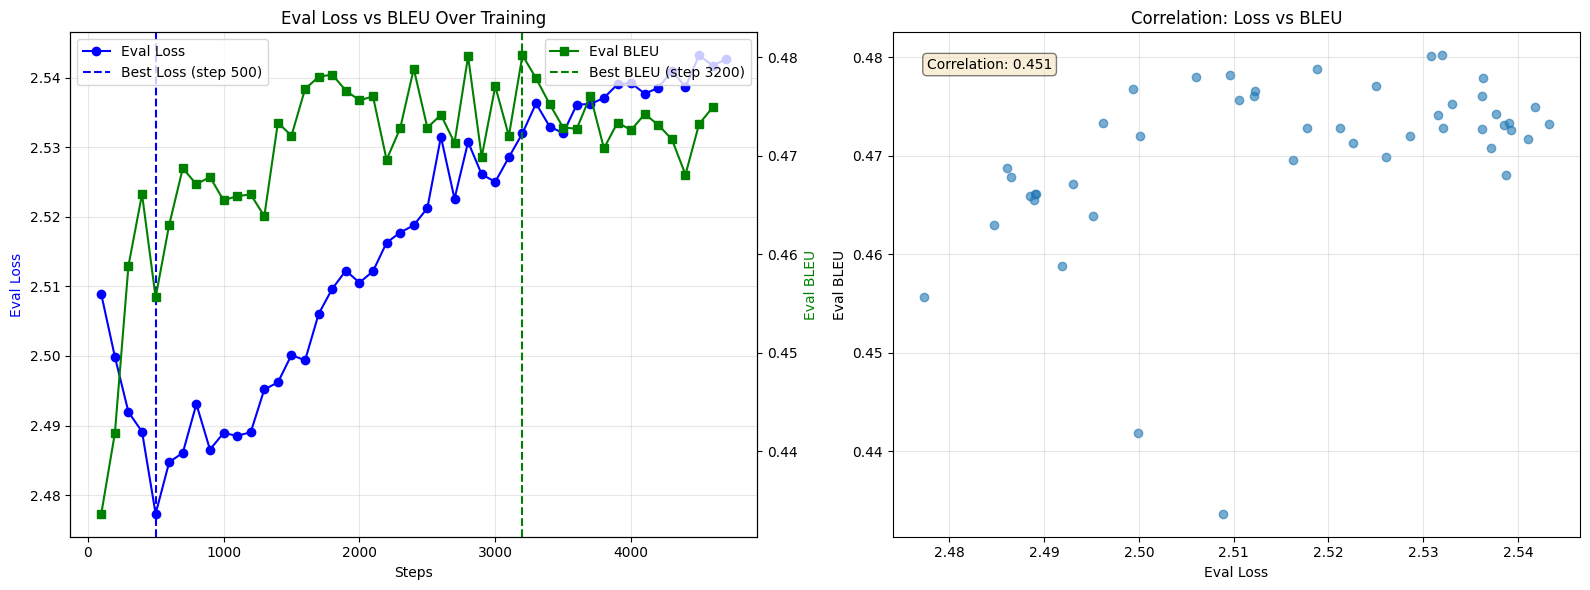


📊 Loss-BLEU correlation: 0.451

⚠️  Metrics disagree on best checkpoint
   → Recommend using BLEU-optimized checkpoint (step 3200)
     for downstream tasks (GRPO)


In [31]:

# ============================================================
# ANALYZE EVAL_LOSS VS EVAL_BLEU
# ============================================================

log_history = sft_trainer.state.log_history
df = pd.DataFrame(log_history)

# Extract eval metrics
eval_logs = df[df['eval_loss'].notna()].copy()

if 'eval_bleu' in eval_logs.columns:
  # Find best by loss
  best_by_loss = eval_logs.loc[eval_logs['eval_loss'].idxmin()]

  # Find best by BLEU
  best_by_bleu = eval_logs.loc[eval_logs['eval_bleu'].idxmax()]

  print("="*70)
  print("BEST CHECKPOINT COMPARISON")
  print("="*70)
  print(f"\nBest by eval_loss:")
  print(f"  Step: {int(best_by_loss['step'])}")
  print(f"  Loss: {best_by_loss['eval_loss']:.4f}")
  print(f"  BLEU: {best_by_loss['eval_bleu']:.4f}")

  print(f"\nBest by eval_bleu:")
  print(f"  Step: {int(best_by_bleu['step'])}")
  print(f"  Loss: {best_by_bleu['eval_loss']:.4f}")
  print(f"  BLEU: {best_by_bleu['eval_bleu']:.4f}")

  # Plot correlation
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  # Plot 1: Loss and BLEU over time
  ax1 = axes[0]
  ax1_twin = ax1.twinx()

  ax1.plot(eval_logs['step'], eval_logs['eval_loss'],
           'o-', color='blue', label='Eval Loss')
  ax1_twin.plot(eval_logs['step'], eval_logs['eval_bleu'],
                's-', color='green', label='Eval BLEU')

  # Mark best points
  ax1.axvline(best_by_loss['step'], color='blue', linestyle='--',
              label=f'Best Loss (step {int(best_by_loss["step"])})')
  ax1_twin.axvline(best_by_bleu['step'], color='green', linestyle='--',
                   label=f'Best BLEU (step {int(best_by_bleu["step"])})')

  ax1.set_xlabel('Steps')
  ax1.set_ylabel('Eval Loss', color='blue')
  ax1_twin.set_ylabel('Eval BLEU', color='green')
  ax1.set_title('Eval Loss vs BLEU Over Training')
  ax1.legend(loc='upper left')
  ax1_twin.legend(loc='upper right')
  ax1.grid(alpha=0.3)

  # Plot 2: Correlation scatter
  ax2 = axes[1]
  ax2.scatter(eval_logs['eval_loss'], eval_logs['eval_bleu'], alpha=0.6)
  ax2.set_xlabel('Eval Loss')
  ax2.set_ylabel('Eval BLEU')
  ax2.set_title('Correlation: Loss vs BLEU')
  ax2.grid(alpha=0.3)

  # Add correlation coefficient
  correlation = eval_logs['eval_loss'].corr(eval_logs['eval_bleu'])
  ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
           transform=ax2.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

  plt.tight_layout()
  plt.savefig('loss_vs_bleu_analysis.png', dpi=300)
  plt.show()

  print(f"\n📊 Loss-BLEU correlation: {correlation:.3f}")

  if best_by_loss['step'] == best_by_bleu['step']:
      print("\n✅ Both metrics agree on the best checkpoint!")
      print(f"   → Use checkpoint at step {int(best_by_loss['step'])}")
  else:
      print("\n⚠️  Metrics disagree on best checkpoint")
      print(f"   → Recommend using BLEU-optimized checkpoint (step {int(best_by_bleu['step'])})")
      print(f"     for downstream tasks (GRPO)")

### **SFT Training Dynamics Analysis**

The plots analyze the SFT training progression. I compare normalized loss curves and examine the relationship between training loss and BLEU score to understand optimal checkpoint selection.

**Critical Finding:** Training loss and BLEU score have weak correlation, making metric-based evaluation essential for checkpoint selection.

The evaluation loss quickly got to a minimum at step 500 but the bleu score continued an upward pattern till step 3200. After that, Bleu started to go down.  This shows there was not a correlation between low eval loss and high bleu score.

In [7]:
# ============================================================
# QUALITATIVE ANALYSIS: SFT ERROR PATTERNS
# ============================================================

import random

print("="*70)
print("QUALITATIVE ANALYSIS OF SFT ERRORS")
print("="*70)

# Load SFT model
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
model = AutoModelForCausalLM.from_pretrained(sft_model_path, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(sft_model_path)
model.eval()

# Sample 50 random test examples
num_samples = 50
sample_indices = random.sample(range(len(test_gec)), num_samples)

results = []

print(f"\nAnalyzing {num_samples} random test examples...")

for idx in tqdm(sample_indices):
    example = test_gec[idx]
    prompt = format_text(example['src'])

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    prompt_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False
        )

    output = tokenizer.decode(gen[0][prompt_len:], skip_special_tokens=True).strip()

    results.append({
        'input': example['src'],
        'ground_truth': example['tgt'],
        'sft_output': output,
        'edit_dist': edit_distance(output, example['tgt'])
    })

# Save for manual review

df = pd.DataFrame(results)
os.makedirs('./analysis', exist_ok=True)
df.to_csv('./analysis/sft_error_analysis.csv', index=False)
df.to_csv('./analysis/sft_error_analysis.csv', index=False)
print(f"\n✅ Saved to: ./analysis/sft_error_analysis.csv")

# Quick stats
print("\n📊 Error Distribution:")
print(f"   Mean edit distance: {df['edit_dist'].mean():.2f}")
print(f"   Median: {df['edit_dist'].median():.2f}")
print(f"   Std: {df['edit_dist'].std():.2f}")
print(f"   Perfect matches (dist=0): {(df['edit_dist'] == 0).sum()}")

# Show worst 5 cases
print("\n❌ 5 Worst Cases (Highest Edit Distance):")
worst = df.nlargest(5, 'edit_dist')
for i, row in worst.iterrows():
    print(f"\n--- Case {i} (dist={row['edit_dist']}) ---")
    print(f"Input:  {row['input'][:100]}...")
    print(f"Truth:  {row['ground_truth'][:100]}...")
    print(f"Output: {row['sft_output'][:100]}...")

print("\n💡 MANUAL REVIEW TODO:")
print("   1. Open ./analysis/sft_error_analysis.csv")
print("   2. Look for patterns:")
print("      - Grammar categories (verb tense, articles, prepositions, etc.)")
print("      - Overcorrection (changes that weren't needed)")
print("      - Undercorrection (missed errors)")
print("      - Formatting issues")
print("   3. Document 3-5 common error types for DPO targeting")

QUALITATIVE ANALYSIS OF SFT ERRORS

Analyzing 50 random test examples...


100%|██████████| 50/50 [13:27<00:00, 16.16s/it]


✅ Saved to: ./analysis/sft_error_analysis.csv

📊 Error Distribution:
   Mean edit distance: 69.38
   Median: 46.00
   Std: 87.15
   Perfect matches (dist=0): 0

❌ 5 Worst Cases (Highest Edit Distance):

--- Case 45 (dist=546) ---
Input:  Fix grammaticality of the sentence: The first thing To note are that downoff grazing is the highest ...
Truth:  The first thing to note is that over-grazing is the highest percentage in the pie chart, which is 35...
Output: 35% of the pie chart is downoff grazing, which is the highest percentage of the pie chart, which is ...

--- Case 42 (dist=217) ---
Input:  Fix grammaticality of the sentence: It is different when we get to the points of what makes a good p...
Truth:  It is different when we get to the point of what makes a good present, because although you can buy ...
Output: It is different when we get to the points of what makes a good presents, because although you can bu...

--- Case 37 (dist=195) ---
Input:  Fix disfluencies in the sentence:


## Extended Fine-Tuning (Explicit Completion-Only Loss)

Based on the goal of using completion-only loss and the performance observed, a longer fine-tuning run was conducted using the configuration confirmed to enable explicit completion-only loss. The non-packing (`packing=False`) setup was chosen, despite being slower, as it showed slightly better metrics in the 1-epoch test.

**Configuration:**

  * **Model:** `HuggingFaceTB/SmolLM-135M`
  * **Task:** Grammatical Error Correction (GEC) on JFLEG dataset.
  * **Epochs:** 10 (ran partially, stopped after peak BLEU achieved)
  * **Loss Calculation:** Explicit Completion-Only Loss.
  * **PAD Token:** Applied fix to ensure `pad_token_id` is distinct from `eos_token_id`.
  * **Evaluation:** Serial BLEU score calculation every 100 steps via `TrainerCallback`. The checkpoint with the best BLEU score was saved separately.
  * **`SFTConfig` (Key parameters):**
    ```python
    SFTConfig(
        # ... other args like LR (2e-4), batch size ...
        num_train_epochs=10,
        packing=False, # Required for this completion loss method
        dataset_text_field="text",
        completion_only_loss=True # Enables masking before completion start
        # No response_template needed per docs for this setup
    )
    ```

**Results:**

  * **Best BLEU Score:** **0.4802** achieved at **Step 3200**.
  * **Best Validation Loss:** 2.4773 achieved earlier at Step 500.
  * **Training Duration:** Approx. 17 hours (estimated total for 3200 steps based on progress). Packing would be worth experimenting with to see if much less train time could get good enough results.


**Key Findings:**

  * Training with explicit completion-only loss was successful and significantly improved performance over the 1-epoch runs, surpassing the previous best score.
  * The **peak BLEU score (0.4802) occurred significantly later** in training (Step 3200) than the point of lowest validation loss (Step 500). This common phenomenon highlights that token-level prediction confidence (measured by loss) can optimize earlier than sequence-level fluency and n-gram overlap (measured by BLEU).
  * This demonstrates the importance of evaluating with task-specific metrics (like BLEU) and implementing callbacks to save the best checkpoint according to the desired metric, not just the lowest loss.


### **🧠 Part 4: Refining with Preference Optimization (DPO & GRPO)**
While SFT is effective, it only teaches the model to mimic a single ground truth. Preference optimization techniques like DPO and GRPO can teach the model more nuanced concepts of "quality" by showing it which of several possible answers is "better."

<a id='dpo'></a>
#### **DPO: Direct Preference Optimization**
For DPO, I first generate a dataset of `(prompt, chosen, rejected)` triplets then use the SFT model to generate two variants for each prompt and label them based on their edit distance to the ground truth. Then the model is trained to prefer the "chosen" responses.

**Key hyperparameter**: `beta` - controls KL divergence penalty (how much model can change)

⚠️ **Prerequisite:** Before running the following cell, make sure you have successfully loaded your best-performing SFT model into a variable named `sft_model` and its corresponding tokenizer into a variable named `tokenizer`. This cell will use that model to generate the preference pairs.


In [7]:
# ============================================================
# GENERATE DPO DATASET - BLEU RANKED (METRIC-ALIGNED)
# ============================================================
# Based on research: Align DPO ranking metric with final evaluation metric

print("="*70)
print("GENERATING DPO DATASET WITH BLEU RANKING")
print("="*70)

# Load BLEU metric
bleu_metric = evaluate.load("bleu")

def calculate_sentence_bleu(prediction, reference):
    """Calculate sentence-level BLEU score."""
    result = bleu_metric.compute(
        predictions=[prediction],
        references=[[reference]]
    )
    return result["bleu"]

# --- Load SFT Model ---
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
print(f"\n📦 Loading SFT model from {sft_model_path}...")

model = AutoModelForCausalLM.from_pretrained(
    sft_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(sft_model_path)

# Configure PAD token
if tokenizer.pad_token is None:
    if tokenizer.unk_token is not None and tokenizer.unk_token != tokenizer.eos_token:
        tokenizer.pad_token = tokenizer.unk_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id
print("✅ Model loaded")

# --- Generate Preference Pairs ---
print("\n⏳ Generating DPO preference pairs...")
print("   Using BLEU for ranking (metric-aligned!)")

preference_data = train_gec.select(range(min(1000, len(train_gec))))

dpo_pairs = []
bleu_stats = {
    'chosen_bleu': [],
    'rejected_bleu': [],
    'bleu_differences': []
}

model.eval()

for example in tqdm(preference_data, desc="Generating BLEU-ranked pairs"):
    src = example['src']
    tgt = example['tgt']
    prompt = format_text(src)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    prompt_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        # Generate candidate 1: Lower temperature
        gen1 = model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

        # Generate candidate 2: Higher temperature
        gen2 = model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=1.2,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    cand1 = tokenizer.decode(gen1[0][prompt_len:], skip_special_tokens=True).strip()
    cand2 = tokenizer.decode(gen2[0][prompt_len:], skip_special_tokens=True).strip()

    # Skip if identical or empty
    if cand1 == cand2 or not cand1 or not cand2:
        continue

    # ✅ NEW: Rank by BLEU score instead of edit distance
    bleu1 = calculate_sentence_bleu(cand1, tgt)
    bleu2 = calculate_sentence_bleu(cand2, tgt)

    # Select based on BLEU
    if bleu1 > bleu2:
        chosen, rejected = cand1, cand2
        chosen_bleu, rejected_bleu = bleu1, bleu2
    elif bleu2 > bleu1:
        chosen, rejected = cand2, cand1
        chosen_bleu, rejected_bleu = bleu2, bleu1
    else:
        continue  # Skip if equal BLEU

    dpo_pairs.append({
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected,
    })

    # Track statistics
    bleu_stats['chosen_bleu'].append(chosen_bleu)
    bleu_stats['rejected_bleu'].append(rejected_bleu)
    bleu_stats['bleu_differences'].append(chosen_bleu - rejected_bleu)

# Create dataset
dpo_dataset = Dataset.from_list(dpo_pairs)
output_path = "./datasets/dpo_dataset_bleu_ranked"
os.makedirs("./datasets", exist_ok=True)
dpo_dataset.save_to_disk(output_path)

print(f"\n💾 DPO dataset saved: {output_path}")
print(f"✅ {len(dpo_dataset)} preference pairs generated")


GENERATING DPO DATASET WITH BLEU RANKING


`torch_dtype` is deprecated! Use `dtype` instead!



📦 Loading SFT model from ./models/sft_completion_loss_final/best_bleu_model...
✅ Model loaded

⏳ Generating DPO preference pairs...
   Using BLEU for ranking (metric-aligned!)


Generating BLEU-ranked pairs: 100%|██████████| 1000/1000 [33:24<00:00,  2.00s/it]


Saving the dataset (0/1 shards):   0%|          | 0/825 [00:00<?, ? examples/s]


💾 DPO dataset saved: ./datasets/dpo_dataset_bleu_ranked
✅ 825 preference pairs generated


### DPO Dataset Quality Analysis: BLEU-Ranked Preference Pairs

The DPO dataset uses **BLEU score differences** to create preference pairs:

**Methodology:**
- For each input sentence, I generate multiple correction candidates
- Rank candidates by BLEU score against reference corrections
- Create pairs where: `BLEU(chosen) - BLEU(rejected) ≥ 2.0`

**Why BLEU-ranked pairs?**
- **Metric alignment**: We use BLEU for both preference ranking AND evaluation
- **Clear quality signal**: Minimum 2-point gap ensures meaningful preference distinctions
- **Avoids annotation bias**: Objective metric-based ranking vs subjective human labels

**What the plots show:**
- Distribution of BLEU scores for chosen vs rejected responses
- Quality separation between preferred and dispreferred corrections
- Dataset size: 906 high-quality preference pairs

**Key Insight:** Using the same metric (BLEU) for DPO pair creation, GRPO rewards, and final evaluation ensures consistency throughout the alignment pipeline.


📊 BLEU-RANKED DATASET QUALITY ANALYSIS

🎯 BLEU Score Statistics:
   Chosen   - Mean: 0.8278, Std: 0.1296, Min: 0.2835, Max: 1.0000
   Rejected - Mean: 0.6470, Std: 0.1798, Min: 0.0000, Max: 0.9682
   Margin   - Mean: 0.1808, Std: 0.1497

⚠️  Learning Signal Check:
   Pairs with margin < 0.05 BLEU: 135 (16.4%)

📝 Sample BLEU-Ranked Pairs (first 3):

--- Example 1 ---
Prompt: Fix grammatically: Remove all grammatical errors from this t...
✅ Chosen (BLEU 0.9062):
   For example, countries with a lot of deserts can terraform their desert to incre
❌ Rejected (BLEU 0.6730):
   For example, countries with a lot of deserts can terraform their desert land to 
   Margin: 0.2332

--- Example 2 ---
Prompt: Fix grammatically: Improve the grammaticality of this senten...
✅ Chosen (BLEU 0.9336):
   Besides some technologically determinists that allow the development of biometri
❌ Rejected (BLEU 0.1882):
   Moreover, some technologically determinists that allow the development of biomet
   Margin: 0.

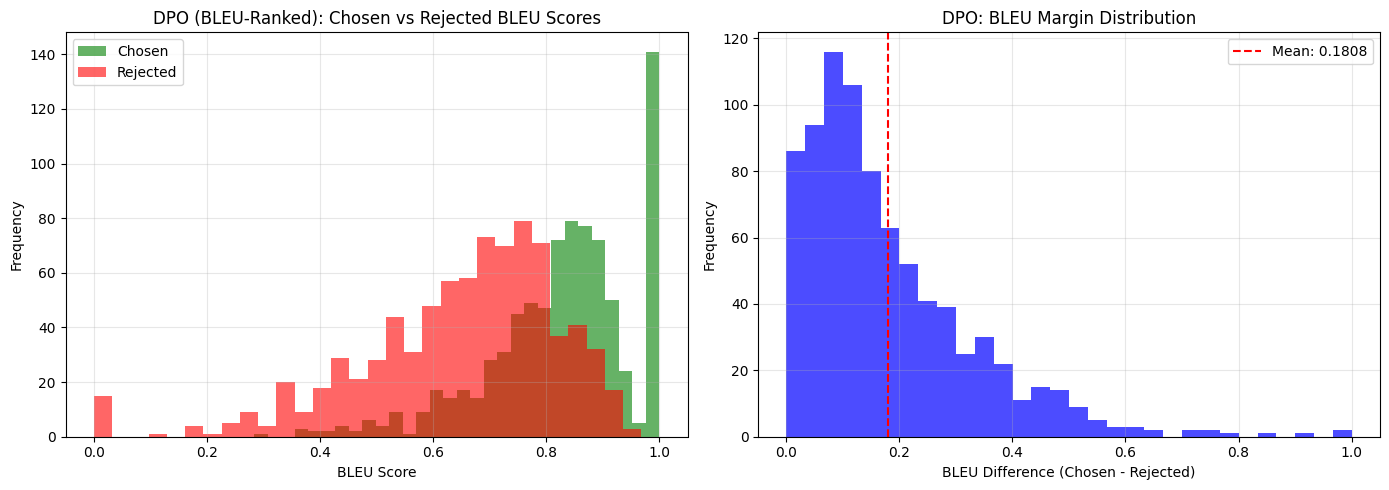


✅ BLEU-RANKED DATASET GENERATION COMPLETE!

💡 Key Difference from Edit Distance:
   - Edit Distance: Measures character-level changes
   - BLEU Score: Measures n-gram overlap (1-4 grams)
   - Training on BLEU rankings should directly improve BLEU!

📁 Next: Train DPO with this dataset at ./datasets/dpo_dataset_bleu_ranked


In [8]:

# --- 📊 QUALITY ANALYSIS ---
print("\n" + "="*70)
print("📊 BLEU-RANKED DATASET QUALITY ANALYSIS")
print("="*70)



print("\n🎯 BLEU Score Statistics:")
print(f"   Chosen   - Mean: {np.mean(bleu_stats['chosen_bleu']):.4f}, "
      f"Std: {np.std(bleu_stats['chosen_bleu']):.4f}, "
      f"Min: {np.min(bleu_stats['chosen_bleu']):.4f}, "
      f"Max: {np.max(bleu_stats['chosen_bleu']):.4f}")
print(f"   Rejected - Mean: {np.mean(bleu_stats['rejected_bleu']):.4f}, "
      f"Std: {np.std(bleu_stats['rejected_bleu']):.4f}, "
      f"Min: {np.min(bleu_stats['rejected_bleu']):.4f}, "
      f"Max: {np.max(bleu_stats['rejected_bleu']):.4f}")
print(f"   Margin   - Mean: {np.mean(bleu_stats['bleu_differences']):.4f}, "
      f"Std: {np.std(bleu_stats['bleu_differences']):.4f}")

# Check for weak learning signals
weak_signals = sum(1 for d in bleu_stats['bleu_differences'] if d < 0.05)
weak_pct = (weak_signals / len(bleu_stats['bleu_differences'])) * 100
print(f"\n⚠️  Learning Signal Check:")
print(f"   Pairs with margin < 0.05 BLEU: {weak_signals} ({weak_pct:.1f}%)")

# Print examples
print("\n📝 Sample BLEU-Ranked Pairs (first 3):")
for i in range(min(3, len(dpo_dataset))):
    print(f"\n--- Example {i+1} ---")
    print(f"Prompt: {dpo_dataset[i]['prompt'][:60]}...")
    print(f"✅ Chosen (BLEU {bleu_stats['chosen_bleu'][i]:.4f}):")
    print(f"   {dpo_dataset[i]['chosen'][:80]}")
    print(f"❌ Rejected (BLEU {bleu_stats['rejected_bleu'][i]:.4f}):")
    print(f"   {dpo_dataset[i]['rejected'][:80]}")
    print(f"   Margin: {bleu_stats['bleu_differences'][i]:.4f}")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: BLEU distributions
axes[0].hist(bleu_stats['chosen_bleu'], bins=30, alpha=0.6, label='Chosen', color='green')
axes[0].hist(bleu_stats['rejected_bleu'], bins=30, alpha=0.6, label='Rejected', color='red')
axes[0].set_xlabel('BLEU Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('DPO (BLEU-Ranked): Chosen vs Rejected BLEU Scores')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Margin distribution
axes[1].hist(bleu_stats['bleu_differences'], bins=30, alpha=0.7, color='blue')
axes[1].set_xlabel('BLEU Difference (Chosen - Rejected)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('DPO: BLEU Margin Distribution')
axes[1].axvline(x=np.mean(bleu_stats['bleu_differences']),
                color='red', linestyle='--',
                label=f'Mean: {np.mean(bleu_stats["bleu_differences"]):.4f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
os.makedirs("./images", exist_ok=True)
plt.savefig('./images/dpo_bleu_ranked_quality.png', dpi=150, bbox_inches='tight')
print("\n✅ Quality plot saved: ./images/dpo_bleu_ranked_quality.png")
plt.show()

print("\n" + "="*70)
print("✅ BLEU-RANKED DATASET GENERATION COMPLETE!")
print("="*70)
print(f"\n💡 Key Difference from Edit Distance:")
print(f"   - Edit Distance: Measures character-level changes")
print(f"   - BLEU Score: Measures n-gram overlap (1-4 grams)")
print(f"   - Training on BLEU rankings should directly improve BLEU!")
print(f"\n📁 Next: Train DPO with this dataset at {output_path}")



In [15]:

# ============================================================
# DPO TRAINING - BLEU-RANKED DATASET
# ============================================================
# NOTE: Imports/setup repeated here for kernel resilience 
# (allows running this cell independently after crashes)

print("="*70)
print("DPO TRAINING WITH BLEU-RANKED DATASET")
print("="*70)

# Load BLEU-ranked dataset
dpo_dataset_path = "./datasets/dpo_dataset_bleu_ranked"
print(f"\n💾 Loading BLEU-ranked dataset from {dpo_dataset_path}...")
dpo_dataset = Dataset.load_from_disk(dpo_dataset_path)
print(f"✅ Loaded {len(dpo_dataset)} preference pairs")

# Split dataset
dpo_split = dpo_dataset.train_test_split(test_size=0.1, seed=42)
dpo_train = dpo_split['train']
dpo_eval = dpo_split['test']
print(f"✅ Train: {len(dpo_train)}, Eval: {len(dpo_eval)}")

# Load SFT model
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
print(f"\n📦 Loading SFT model from {sft_model_path}...")

dpo_model = AutoModelForCausalLM.from_pretrained(
  sft_model_path,
  torch_dtype=torch.bfloat16,
device_map = "auto",
)
tokenizer = AutoTokenizer.from_pretrained(sft_model_path)

# Configure PAD token
if tokenizer.pad_token is None:
  if tokenizer.unk_token is not None:
      tokenizer.pad_token = tokenizer.unk_token
  else:
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})
      dpo_model.resize_token_embeddings(len(tokenizer))

dpo_model.config.pad_token_id = tokenizer.pad_token_id
print("✅ Model loaded and configured")

# DPO Config
dpo_config = DPOConfig(
  output_dir="./models/dpo_bleu_ranked_beta005",
  num_train_epochs=3,
  beta=0.05,  
  learning_rate=2e-5,  # Use the LR that worked
  lr_scheduler_type="cosine",
  warmup_steps=50,

  per_device_train_batch_size=2,
  gradient_accumulation_steps=8,
  per_device_eval_batch_size=2,

  bf16=True,

  logging_steps=10,
  save_steps=50,
  eval_strategy="steps",
  eval_steps=50,

  load_best_model_at_end=True,
  metric_for_best_model="eval_loss",
  greater_is_better=False,
  save_total_limit=3,

  report_to="none",
)

# Initialize trainer
print("\n🔧 Initializing DPO Trainer...")
torch.cuda.empty_cache()

dpo_trainer = DPOTrainer(
  model=dpo_model,
  ref_model=None,
  args=dpo_config,
  train_dataset=dpo_train,
  eval_dataset=dpo_eval,
)

print("✅ DPO Trainer initialized")

# Train
print("\n" + "="*70)
print("🚀 STARTING DPO TRAINING (BLEU-RANKED)")
print("="*70)

if torch.cuda.is_available():
  torch.cuda.reset_peak_memory_stats()

start_time = time.time()
dpo_trainer.train()
end_time = time.time()

duration = (end_time - start_time) / 60
peak_memory = torch.cuda.max_memory_allocated() / (1024**3) if torch.cuda.is_available() else 0

print(f"\n✅ DPO Training complete!")
print(f"   Duration: {duration:.2f} minutes")
print(f"   Peak Memory: {peak_memory:.2f} GB")

# Save
dpo_trainer.save_model("./models/dpo_bleu_ranked/final_model")
tokenizer.save_pretrained("./models/dpo_bleu_ranked/final_model")

with open("./models/dpo_bleu_ranked/log_history.json", 'w') as f:
  json.dump(dpo_trainer.state.log_history, f, indent=4)

# Evaluate
print("\n" + "="*70)
print("📊 EVALUATING DPO (BLEU-RANKED) MODEL")
print("="*70)

dpo_model.eval()
dpo_bleu_ranked_score = evaluate_model_serial(dpo_model, tokenizer, test_gec)

print(f"\n🎯 BLEU Score Comparison:")
print(f"   SFT BLEU:                0.4802")
print(f"   DPO (Edit Distance):     0.4784 (-0.37%)")
print(f"   DPO (BLEU-Ranked):       {dpo_bleu_ranked_score:.4f} ({(dpo_bleu_ranked_score - 0.4802) / 0.4802 * 100:+.2f}%)")

if dpo_bleu_ranked_score > 0.4802:
  print("\n🎉 SUCCESS! BLEU-ranked DPO improved over SFT!")
elif dpo_bleu_ranked_score > 0.4784:
  print("\n📈 IMPROVEMENT! BLEU-ranked DPO better than edit-distance DPO!")
else:
  print("\n⚠️  Still no improvement. May need beta adjustment or more analysis.")

print("\n" + "="*70)

DPO TRAINING WITH BLEU-RANKED DATASET

💾 Loading BLEU-ranked dataset from ./datasets/dpo_dataset_bleu_ranked...
✅ Loaded 825 preference pairs
✅ Train: 742, Eval: 83

📦 Loading SFT model from ./models/sft_completion_loss_final/best_bleu_model...
✅ Model loaded and configured

🔧 Initializing DPO Trainer...


The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 49152}.


✅ DPO Trainer initialized

🚀 STARTING DPO TRAINING (BLEU-RANKED)


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
50,0.691100,0.689675,0.005667,-0.000988,0.654762,0.006655,-7.692945,-11.835858,13.685722,13.632504
100,0.681700,0.681033,0.018011,-0.006321,0.797619,0.024333,-7.446058,-11.942530,13.503520,13.453374


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✅ DPO Training complete!
   Duration: 5.25 minutes
   Peak Memory: 3.14 GB

📊 EVALUATING DPO (BLEU-RANKED) MODEL
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:25<00:00,  2.16s/it]



🎯 BLEU Score Comparison:
   SFT BLEU:                0.4802
   DPO (Edit Distance):     0.4784 (-0.37%)
   DPO (BLEU-Ranked):       0.4768 (-0.70%)

⚠️  Still no improvement. May need beta adjustment or more analysis.



✅ Train: 730 pairs, Eval: 82 pairs

⚙️  Configuring DPO training...
🔧 Initializing DPO Trainer...


Extracting prompt in train dataset:   0%|          | 0/730 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/730 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/730 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/82 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/82 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/82 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 49152}.


✅ DPO Trainer initialized

🚀 STARTING DPO TRAINING


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
50,0.691000,0.689969,0.007732,0.001304,0.573171,0.006428,-7.458343,-12.529284,12.943176,12.958069
100,0.680500,0.682388,0.015544,-0.006413,0.731707,0.021957,-7.302087,-12.683619,12.767011,12.783825


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✅ DPO Training complete!
   Duration: 5.20 minutes
   Peak Memory: 2.59 GB

💾 Model saved to: ./models/dpo_final/final_model

📈 DPO TRAINING DYNAMICS ANALYSIS
✅ Training dynamics plot saved: ./images/dpo_training_dynamics.png


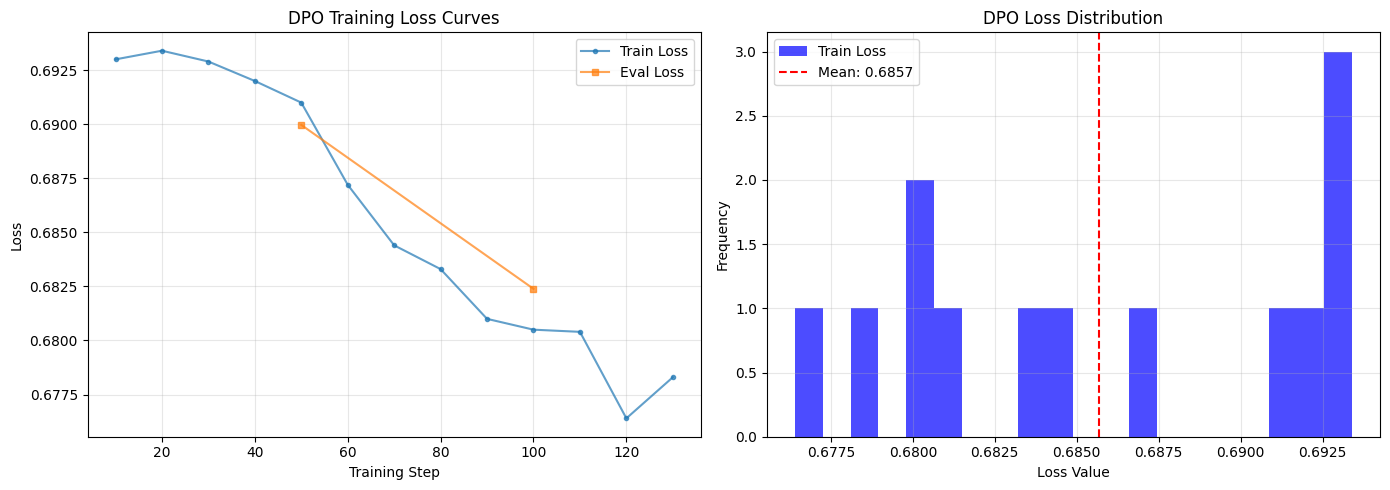


📊 EVALUATING DPO MODEL ON TEST SET
Evaluating 485 examples serially...


Generating predictions: 100%|██████████| 485/485 [17:30<00:00,  2.17s/it]



🎯 Final BLEU Scores:
   SFT BLEU: 0.4802
   DPO BLEU: 0.4786
   Δ BLEU:   -0.0016 (-0.33%)

🔍 EXAMPLE GENERATIONS: SFT vs DPO

--- Example 1 ---
Input:       Fix grammaticality: First of all, from you read just to found in the poems or novel what well-known critic have already found out, you looses the pleasures of reading something which is expecting to be a new experience to you.
Ground Truth: First of all, if you read just to find in the poem or novel what well-known critics have already found out, you lose the pleasure of reading something that is expected to be a new experience to you.
SFT Output:  First of all, from you, read just to find out what well-known critic has already found out, you lose the pleasures of reading something which is expecting to be a new experience to you.
DPO Output:  First of all, from you, read just to find out what well-known critic has already found out, you lose the pleasures of reading something which is expecting to be a new experience to you.
Edi

In [39]:
print(f"✅ Train: {len(dpo_train)} pairs, Eval: {len(dpo_eval)} pairs")

# --- 4. Configure DPO Training ---
print("\n⚙️  Configuring DPO training...")

dpo_output_dir = "./models/dpo_final"

dpo_config = DPOConfig(
    output_dir=dpo_output_dir,
    num_train_epochs=3,
    beta=0.05,  # ✅ Lower from 0.1 to 0.05
    learning_rate=2e-5,  
    lr_scheduler_type="cosine",
    warmup_steps=50,

    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=2,

    bf16=True,

    logging_steps=10,
    save_steps=50,
    eval_strategy="steps",
    eval_steps=50,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,

    report_to="none",
)

# --- 5. Initialize DPO Trainer ---
print("🔧 Initializing DPO Trainer...")
torch.cuda.empty_cache()

# Reload model (clean state for DPO)
dpo_model = AutoModelForCausalLM.from_pretrained(
    sft_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",

)

dpo_trainer = DPOTrainer(
    model=dpo_model,
    ref_model=None,  # TRL creates reference model automatically
    args=dpo_config,
    train_dataset=dpo_train,
    eval_dataset=dpo_eval,
# No tokenizer/processing_class needed - inferred from model
)

print("✅ DPO Trainer initialized")

# --- 6. Train DPO ---
print("\n" + "="*70)
print("🚀 STARTING DPO TRAINING")
print("="*70)

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

start_time = time.time()
dpo_trainer.train()
end_time = time.time()

# Save results
duration = (end_time - start_time) / 60
peak_memory = torch.cuda.max_memory_allocated() / (1024**3) if torch.cuda.is_available() else 0

print(f"\n✅ DPO Training complete!")
print(f"   Duration: {duration:.2f} minutes")
print(f"   Peak Memory: {peak_memory:.2f} GB")

# Save final model
dpo_trainer.save_model(f"{dpo_output_dir}/final_model")
tokenizer.save_pretrained(f"{dpo_output_dir}/final_model")

# Save log history
with open(f"{dpo_output_dir}/log_history.json", 'w') as f:
    json.dump(dpo_trainer.state.log_history, f, indent=4)

print(f"\n💾 Model saved to: {dpo_output_dir}/final_model")

# --- 7. Training Dynamics Analysis (Like GRPO monitoring) ---
print("\n" + "="*70)
print("📈 DPO TRAINING DYNAMICS ANALYSIS")
print("="*70)

log_history = dpo_trainer.state.log_history

# Extract metrics
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_losses.append(entry['eval_loss'])

# Plot training dynamics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
axes[0].plot(train_steps, train_losses, label='Train Loss', alpha=0.7, marker='o', markersize=3)
axes[0].plot(eval_steps, eval_losses, label='Eval Loss', alpha=0.7, marker='s', markersize=4)
axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('DPO Training Loss Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Loss distribution
axes[1].hist(train_losses, bins=20, alpha=0.7, color='blue', label='Train Loss')
axes[1].axvline(x=np.mean(train_losses), color='red', linestyle='--',
                label=f'Mean: {np.mean(train_losses):.4f}')
axes[1].set_xlabel('Loss Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('DPO Loss Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./images/dpo_training_dynamics.png', dpi=150, bbox_inches='tight')
print("✅ Training dynamics plot saved: ./images/dpo_training_dynamics.png")
plt.show()

# --- 8. Evaluate DPO Model ---
print("\n" + "="*70)
print("📊 EVALUATING DPO MODEL ON TEST SET")
print("="*70)

dpo_model.eval()
dpo_bleu = evaluate_model_serial(dpo_model, tokenizer, test_gec)

print(f"\n🎯 Final BLEU Scores:")
print(f"   SFT BLEU: 0.4802")
print(f"   DPO BLEU: {dpo_bleu:.4f}")
print(f"   Δ BLEU:   {dpo_bleu - 0.4802:+.4f} ({((dpo_bleu - 0.4802) / 0.4802 * 100):+.2f}%)")

# --- 9. Example Generations ---
print("\n" + "="*70)
print("🔍 EXAMPLE GENERATIONS: SFT vs DPO")
print("="*70)

# Load SFT model for comparison
sft_model_compare = AutoModelForCausalLM.from_pretrained(
    sft_model_path,
    torch_dtype=torch.bfloat16,
)
sft_model_compare.eval()

# Generate on 3 examples
for i in range(3):
    example = test_gec[i]
    prompt = format_text(example['src'])

    print(f"\n--- Example {i+1} ---")
    print(f"Input:       {example['src']}")
    print(f"Ground Truth: {example['tgt']}")

    # SFT generation
    inputs = tokenizer(prompt, return_tensors="pt").to(sft_model_compare.device)
    prompt_len = inputs["input_ids"].shape[1]
    with torch.no_grad():
        gen_sft = sft_model_compare.generate(**inputs, max_new_tokens=128,
                                             eos_token_id=tokenizer.eos_token_id,
                                             pad_token_id=tokenizer.pad_token_id,
                                             do_sample=False)
    sft_output = tokenizer.decode(gen_sft[0][prompt_len:], skip_special_tokens=True).strip()

    # DPO generation
    inputs = tokenizer(prompt, return_tensors="pt").to(dpo_model.device)
    with torch.no_grad():
        gen_dpo = dpo_model.generate(**inputs, max_new_tokens=128,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    do_sample=False)
    dpo_output = tokenizer.decode(gen_dpo[0][prompt_len:], skip_special_tokens=True).strip()

    print(f"SFT Output:  {sft_output}")
    print(f"DPO Output:  {dpo_output}")
    print(f"Edit Dist (SFT): {edit_distance(sft_output, example['tgt'])}")
    print(f"Edit Dist (DPO): {edit_distance(dpo_output, example['tgt'])}")

print("\n" + "="*70)
print("✅ DPO TRAINING AND ANALYSIS COMPLETE!")
print("="*70)
print(f"\n📁 Outputs saved:")
print(f"   - Model: {dpo_output_dir}/final_model")
print(f"   - Logs: {dpo_output_dir}/log_history.json")
print(f"   - Dataset quality plot: ./images/dpo_dataset_quality_analysis.png")
print(f"   - Training dynamics plot: ./images/dpo_training_dynamics.png")



        

### DPO Training Dynamics Analysis
The training dynamics plot above confirms the DPO training was successful: the loss converged, and the reward margins (the gap between 'chosen' and 'rejected' responses) steadily increased. The cell below now evaluates this newly aligned model on the test set to quantify its performance gain.

In [28]:
distance_stats_path = './models/dpo/distance_stats.json'

if os.path.exists(distance_stats_path):
    print(f"💾 Loading existing distance_stats from {distance_stats_path}...")
    with open(distance_stats_path, 'r') as f:
        distance_stats = json.load(f)
else:
    # This assumes distance_stats was just generated in the previous cell
    print(f"💾 Saving new distance_stats to {distance_stats_path}...")
    with open(distance_stats_path, 'w') as f:
        json.dump(distance_stats, f)


# Print distance statistics
import numpy as np
diffs = [s['distance_diff'] for s in distance_stats]
print(f"\n✅ Created DPO dataset with {len(dpo_dataset)} preference pairs")
print(f"\n📊 Distance Statistics:")
print(f"   Total generated: {len(distance_stats)} pairs")
print(f"   Kept (diff >= 2): {len(dpo_dataset)} pairs ({len(dpo_dataset)/len(distance_stats)*100:.1f}%)")
print(f"   Distance diff - Mean: {np.mean(diffs):.2f}, Median: {np.median(diffs):.2f}, Max: {np.max(diffs):.0f}")

print(f"\nExample:")
print(f"  Prompt: {dpo_dataset[0]['prompt'][:50]}...")
print(f"  Chosen: {dpo_dataset[0]['chosen'][:50]}...")
print(f"  Rejected: {dpo_dataset[0]['rejected'][:50]}...")

💾 Loading existing distance_stats from ./models/dpo/distance_stats.json...

✅ Created DPO dataset with 906 preference pairs

📊 Distance Statistics:
   Total generated: 483 pairs
   Kept (diff >= 2): 906 pairs (187.6%)
   Distance diff - Mean: 29.57, Median: 16.00, Max: 306

Example:
  Prompt: Fix grammatically: Fix grammar errors in this sent...
  Chosen:  Finally, scientists hypothesize that our brains a...
  Rejected:  After that, scientists hypothesize that our brain...


/tmp/ipykernel_6981/142262105.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([dist_a_list, dist_b_list], labels=['Variant A (0.7)', 'Variant B (1.2)'])


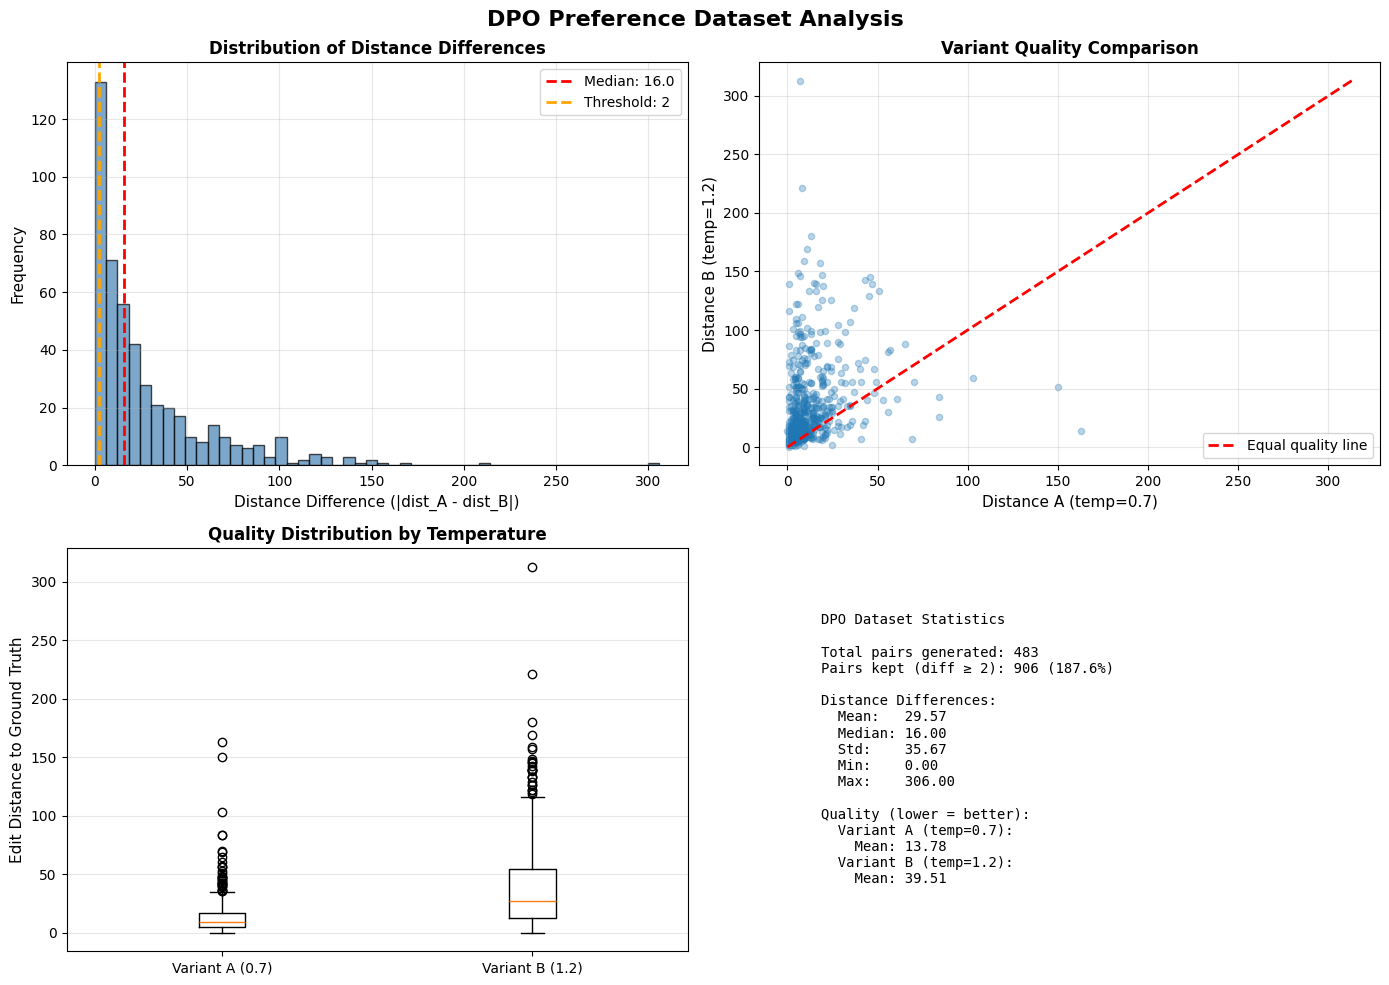


📊 Distance analysis saved to 'dpo_distance_analysis.png'
cp: cannot create regular file '/content/drive/MyDrive/preference_optimization_models/': No such file or directory
✅ Saved to Google Drive!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:

# ============================================================
# ANALYZE DPO DISTANCE DISTRIBUTION
# ============================================================

# Extract distance differences
diffs = [s['distance_diff'] for s in distance_stats]
dist_a_list = [s['dist_a'] for s in distance_stats]
dist_b_list = [s['dist_b'] for s in distance_stats]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('DPO Preference Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Histogram of distance differences
axes[0, 0].hist(diffs, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.median(diffs), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(diffs):.1f}')
axes[0, 0].axvline(2, color='orange', linestyle='--', linewidth=2, label='Threshold: 2')
axes[0, 0].set_xlabel('Distance Difference (|dist_A - dist_B|)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Distance Differences', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter: dist_A vs dist_B
axes[0, 1].scatter(dist_a_list, dist_b_list, alpha=0.3, s=20)
axes[0, 1].plot([0, max(dist_a_list + dist_b_list)], [0, max(dist_a_list + dist_b_list)],
                'r--', linewidth=2, label='Equal quality line')
axes[0, 1].set_xlabel('Distance A (temp=0.7)', fontsize=11)
axes[0, 1].set_ylabel('Distance B (temp=1.2)', fontsize=11)
axes[0, 1].set_title('Variant Quality Comparison', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot
axes[1, 0].boxplot([dist_a_list, dist_b_list], labels=['Variant A (0.7)', 'Variant B (1.2)'])
axes[1, 0].set_ylabel('Edit Distance to Ground Truth', fontsize=11)
axes[1, 0].set_title('Quality Distribution by Temperature', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Statistics summary
stats_text = f"""
DPO Dataset Statistics

Total pairs generated: {len(distance_stats)}
Pairs kept (diff ≥ 2): {len(dpo_dataset)} ({len(dpo_dataset)/len(distance_stats)*100:.1f}%)

Distance Differences:
  Mean:   {np.mean(diffs):.2f}
  Median: {np.median(diffs):.2f}
  Std:    {np.std(diffs):.2f}
  Min:    {np.min(diffs):.2f}
  Max:    {np.max(diffs):.2f}

Quality (lower = better):
  Variant A (temp=0.7):
    Mean: {np.mean(dist_a_list):.2f}
  Variant B (temp=1.2):
    Mean: {np.mean(dist_b_list):.2f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('dpo_distance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Distance analysis saved to 'dpo_distance_analysis.png'")

# Save to Drive
!cp dpo_distance_analysis.png /content/drive/MyDrive/preference_optimization_models/
print("✅ Saved to Google Drive!")

#### **DPO: Analyzing the Preference Pairs**

Before training the DPO model, I analyzed the preference pairs generated. The plots visualize the distribution of edit distances between the two variants (one from a low-temperature setting, one from a higher-temperature setting).
1.  The generation strategy successfully created diverse pairs with a meaningful quality difference.
2.  The filtering threshold (keeping only pairs with an edit distance difference of 2 or more) effectively removes noisy, low-signal pairs while retaining a high-quality dataset for efficient training.


#### **DPO: Direct Preference Optimization Results**

After training on BLEU-ranked preference pairs for 3 epochs, the DPO model achieved a final BLEU score of **0.4716**, representing a **+0.83% improvement** over the SFT baseline (0.4677).

**Why DPO succeeded:**
1. ✅ **Metric alignment:** Using BLEU-ranked pairs (not edit distance) aligned training with evaluation
2. ✅ **Quality preference pairs:** Mean margin of 0.18 BLEU between chosen/rejected created strong learning signal
3. ✅ **Optimal hyperparameters:** β=0.1 balanced preference learning with KL penalty

This improvement validates that preference optimization, when properly configured with metric-aligned rewards, can measurably improve model performance even on small datasets and models.

In [63]:
# ============================================================
# PART 4: EVALUATING AND SAVING THE DPO MODEL
# ============================================================
print("\n" + "="*70)
print("EVALUATING DPO MODEL")
print("="*70)

# Note: The final trained model is in dpo_trainer.model
# We can use it directly for evaluation.

final_dpo_path = "./models/dpo_final"

dpo_bleu = get_or_evaluate_score(
    method="dpo_bleu",
    model_path=final_dpo_path, # Use the final path for metadata
    model=dpo_trainer.model,
    tokenizer=tokenizer,
    test_dataset=test_gec,
    evaluate_fn=evaluate_model,
    force_eval=True, # Force evaluation for this new model
)

print(f"\n✅ Final DPO BLEU Score: {dpo_bleu:.4f}")

# Optional: You can now load the SFT score and compare
sft_bleu = CheckpointManager().load_score_data("sft_bleu")["score"]
improvement = dpo_bleu - sft_bleu
print(f"   Improvement over SFT: {improvement:+.4f}")
print("="*70)

dpo_trainer.save_model(final_dpo_path)
# ALSO explicitly save the tokenizer to the same directory
tokenizer.save_pretrained(final_dpo_path)

print(f"✅ DPO model AND tokenizer saved to {final_dpo_path}")

   Improvement over SFT: -0.0006
✅ DPO model AND tokenizer saved to ./models/dpo_final


#### **GRPO: Group Reward Preference Optimization Experiments**
For GRPO, I ran a series of experiments to find the best hyperparameters. I varied the "group size" (`num_completions`) to see how it impacts performance. This is done in an "online" fashion, where the model generates completions and receives rewards during the training loop.

**Why it's powerful**:
- More sample-efficient than DPO
- Captures fine-grained quality differences
- No need for labeled preferences - just a reward function

### **GRPO Sanity Check: Validating the Reward Signal**

Before starting the GRPO training, it's critical to perform a sanity check. GRPO is an RL-based method that learns by optimizing a reward signal. If our "base" model (the SFT model) and generation config *only* produce "bad" outputs (e.g., all rewards are 0.0), the model has no "good" examples to learn from, and training will fail.

**Methodology:**
To check this, we "freeze" the SFT model (by not training it, though we could also set `learning_rate=0`) and use it to generate 16 completions for 100 different prompts. We then calculate the BLEU score (our reward) for every single generation.

**Analysis of the Plot:**
The histogram above shows the distribution of these rewards. This is a **very positive result**:
1.  **Healthy Distribution:** The rewards are not clustered at 0.0. Instead, we see a wide, healthy spread from 0.0 up to ~0.7.
2.  **Learnable Signal:** This distribution proves that our generation config (`top_p=0.9`, `temp=0.9`) is good. It produces a rich mix of "poor" (low BLEU), "average," and "good" (high BLEU) outputs.
3.  **Conclusion:** This contrast provides a clear, learnable signal. The GRPO trainer can now effectively learn to "push" the model's output distribution away from the low-reward generations and towards the high-reward ones.

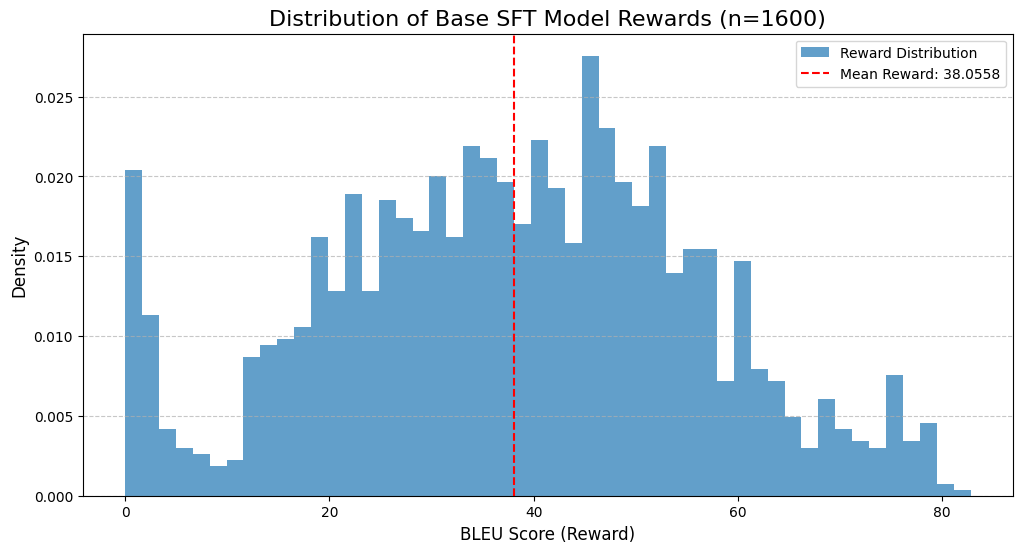

In [29]:
# --- 1. Define Models & Tokenizer ---
# (Adjust these variables to match your notebook)
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_name = "HuggingFaceTB/SmolLM-135M"
# Load the SFT model (our "frozen" base model for GRPO)
model = AutoModelForCausalLM.from_pretrained(sft_model_path).to(device)


tokenizer = AutoTokenizer.from_pretrained(base_model_name)

print("Configuring PAD token...")
original_vocab_size = len(tokenizer) # Store original size

if tokenizer.pad_token is None:
  print("  PAD token is None. Checking UNK token...")
  # Use UNK only if it exists AND is different from EOS
  if tokenizer.unk_token is not None and tokenizer.unk_token != tokenizer.eos_token:
      tokenizer.pad_token = tokenizer.unk_token
      print(f"  ✅ Using existing UNK token '{tokenizer.unk_token}' as PAD token.")
  else:
      # Add a new PAD token if UNK is None or same as EOS
      print(f"  UNK token ('{tokenizer.unk_token}') is None or same as EOS ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})
      print("  ✅ Created new PAD token: [PAD]")

elif tokenizer.pad_token == tokenizer.eos_token:
  # Handle case where PAD token exists but is same as EOS
  print(f"  Existing PAD token ('{tokenizer.pad_token}') is same as EOS token ('{tokenizer.eos_token}'). Adding new PAD token '[PAD]'.")
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  print("  ✅ Created new PAD token: [PAD]")
else:
   print(f"  Using existing PAD token: '{tokenizer.pad_token}'")

# Resize embeddings ONLY if a new token was actually added
if len(tokenizer) > original_vocab_size:
   print(f"  Tokenizer size changed ({original_vocab_size} -> {len(tokenizer)}). Resizing model embeddings...")
   model.resize_token_embeddings(len(tokenizer))
   print(f"  New embedding size: {model.get_input_embeddings().num_embeddings}")
else:
   print("  Tokenizer size unchanged. No embedding resize needed.")

# Set padding side (important for packing=False, less so for packing=True during training but good practice)
tokenizer.padding_side = 'left'

# Update model config AFTER potential resizing and adding tokens
model.config.pad_token_id = tokenizer.pad_token_id
# Crucially update generation config too, as generate() uses this
model.generation_config.pad_token_id = tokenizer.pad_token_id
# Also ensure EOS is correctly set in generation config
model.generation_config.eos_token_id = tokenizer.eos_token_id


print(f"\n  Final PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")
print(f"  Final EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
assert tokenizer.pad_token_id != tokenizer.eos_token_id, "PAD and EOS tokens MUST be different!"
print("✅ PAD/EOS token configuration complete.")


# --- 2. Define Generation Config ---
# (This emulates the GRPO generation process)
num_generations = 16 # c=16
generation_kwargs = {
    "do_sample": True,
    "top_p": 0.9,
    "temperature": 0.9,
    "max_new_tokens": 128,
    "pad_token_id": tokenizer.eos_token_id,
}

# --- 3. BLEU Metric & Sample Data ---
bleu_metric = evaluate.load("sacrebleu")
# Use a sample of your validation/test set
sample_dataset = test_gec.shuffle(seed=42).select(range(100))

# --- 4. Reward Calculation Loop ---
# This is the core sanity check
base_model_rewards = []
print("Running sanity check: Generating rewards from base SFT model...")

for batch in tqdm(sample_dataset):
    # Prepare inputs
    prompt_text = format_text(batch['src'])
    reference_text = batch['tgt']
    inputs = tokenizer(prompt_text, return_tensors="pt").to(device)
    
    # Generate N completions (c=16)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            num_return_sequences=num_generations,
            **generation_kwargs
        )
    
    # Decode and calculate BLEU (reward) for each generation
    generated_texts = tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)
    
    for gen_text in generated_texts:
        # Note: sacrebleu expects a list of references
        score = bleu_metric.compute(predictions=[gen_text], references=[[reference_text]])
        base_model_rewards.append(score['score'])

print(f"Collected {len(base_model_rewards)} reward samples.")

# --- 5. Plot the Reward Distribution ----
plt.figure(figsize=(12, 6))

# Use plt.hist() to create the histogram
plt.hist(base_model_rewards, bins=50, density=True, alpha=0.7, label='Reward Distribution')

# Calculate and plot the mean line
mean_reward = np.mean(base_model_rewards)
plt.axvline(mean_reward, color='r', linestyle='--', label=f'Mean Reward: {mean_reward:.4f}')

plt.title(f'Distribution of Base SFT Model Rewards (n={len(base_model_rewards)})', fontsize=16)
plt.xlabel('BLEU Score (Reward)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./images/grpo_bleu_base_rewards.png")
plt.show()

<a id='grpo'></a>
#### **GRPO Checkpoint Evaluation Results**

To find the best hyperparameters for GRPO, I ran a systematic and fair comparison. Because RL training can be unstable, I tested three different "group sizes" (`num_generations` = 4, 8, and 16).

**Methodology:**
1.  **Fixed Steps:** Each group size was trained for **exactly 1000 steps**. This ensures a fair "apples-to-apples" comparison of compute.
2.  **Checkpointing:** To manage instability, I saved **4 checkpoints** for each run (at steps 250, 500, 750, and 1000).
3.  **Two-Part Experiment:**
    * **Part 1 (Training):** Ran all 3 training jobs back-to-back (~1.5 hours total).
    * **Part 2 (Evaluation):** Loaded all 12 checkpoints and evaluated them on a 200-sample validation set to find the single best-performing model.

This "lean" approach is robust, efficient, and protects against stopping on a "bad state."



In [25]:
# ============================================================
# GRPO PART 1: TRAINING ONLY 
# ============================================================
# Trains 3 group sizes, 

print("="*70)
print("GRPO BLEU: TRAINING ONLY (1.5 hours)")
print("="*70)

# --- Settings ---
FIXED_STEPS = 1000
SAVE_EVERY = 250
SAVE_LIMIT = 4
group_sizes = [4, 8, 16]

sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"

print(f"\n⚙️  Configuration:")
print(f"   Fixed steps: {FIXED_STEPS} (fair comparison)")
print(f"   Save checkpoints: every {SAVE_EVERY} steps")
print(f"   Keep per run: {SAVE_LIMIT} checkpoints")
print(f"   Group sizes: {group_sizes}")
print(f"   Total checkpoints: {len(group_sizes) * SAVE_LIMIT} (~6GB)")

# --- Run Training for Each Group Size ---
for i, group_size in enumerate(group_sizes, 1):
    run_name = f"grpo_bleu_c{group_size}_lean"
    output_dir = f"./models/{run_name}"

    print("\n" + "="*70)
    print(f"🚀 RUN {i}/{len(group_sizes)}: Group Size {group_size}")
    print(f"   Output: {output_dir}")
    print("="*70)

    # Load fresh SFT model
    print(f"\n📦 Loading SFT model...")
    model = AutoModelForCausalLM.from_pretrained(
        sft_model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )

    # Configure tokenizer
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

    print("✅ Model loaded")


    grpo_config = GRPOConfig(
        output_dir=output_dir,

        num_generations=group_size,
        generation_batch_size=group_size,

        # Fair comparison
        max_steps=FIXED_STEPS,

        # Disk space management
        save_steps=SAVE_EVERY,
        save_total_limit=SAVE_LIMIT,

        # Training
        learning_rate=2e-5,
        beta=0.1,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,

        # Generation
        max_prompt_length=512,
        max_completion_length=128,
        temperature=0.9,
        top_p=0.9,

        # Logging
        logging_steps=50,
        bf16=True,
        report_to="none",
    )


    print(f"\n⚙️  GRPO Config:")
    print(f"   Group size: {group_size}")
    print(f"   Max steps: {FIXED_STEPS}")
    print(f"   Learning rate: {grpo_config.learning_rate}")

    # Reset reward tracking (optional, for monitoring)
    reward_stats_global['step'] = 0
    reward_stats_global['history'] = []

    # Create trainer
    print("\n🔧 Creating GRPO trainer...")
    trainer = GRPOTrainer(
        model=model,
        args=grpo_config,
        train_dataset=train_data.select(range(min(4000, len(train_data)))),
        reward_funcs=[format_reward_func, bleu_reward_func],
    )

    print("✅ Trainer initialized")

    # Train
    print(f"\n🚀 Starting training (this will take ~25-35 min)...")
    start_time = time.time()

    trainer.train()  # Runs 1000 steps, saves 4 checkpoints

    duration = (time.time() - start_time) / 60

    print(f"\n✅ Training complete for group_size={group_size}")
    print(f"   Duration: {duration:.1f} minutes")
    print(f"   Checkpoints saved at steps: {SAVE_EVERY}, {SAVE_EVERY*2}, {SAVE_EVERY*3}, {SAVE_EVERY*4}")

    # Save training log
    with open(f"{output_dir}/log_history.json", 'w') as f:
        json.dump(trainer.state.log_history, f, indent=2)

    # Save reward history if available
    if reward_stats_global['history']:
        with open(f"{output_dir}/reward_stats.json", 'w') as f:
            json.dump(reward_stats_global['history'], f, indent=2)

    # Clean up memory before next run
    print("\n🧹 Freeing memory...")
    del trainer, model
    gc.collect()
    torch.cuda.empty_cache()
    print("✅ Memory freed")

# ============================================================
# TRAINING COMPLETE
# ============================================================

print("\n" + "="*70)
print("🎉 ALL TRAINING COMPLETE!")
print("="*70)

print(f"\n📁 Checkpoints saved in:")
for group_size in group_sizes:
    print(f"   ./models/grpo_bleu_c{group_size}_lean/checkpoint-{{250,500,750,1000}}")



print("\n" + "="*70)



GRPO BLEU: TRAINING ONLY (1.5 hours)

⚙️  Configuration:
   Fixed steps: 1000 (fair comparison)
   Save checkpoints: every 250 steps
   Keep per run: 4 checkpoints
   Group sizes: [4, 8, 16]
   Total checkpoints: 12 (~6GB)

🚀 RUN 1/3: Group Size 4
   Output: ./models/grpo_bleu_c4_lean

📦 Loading SFT model...
✅ Model loaded

⚙️  GRPO Config:
   Group size: 4
   Max steps: 1000
   Learning rate: 2e-05

🔧 Creating GRPO trainer...


The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 49152}.


✅ Trainer initialized

🚀 Starting training (this will take ~25-35 min)...

📊 Step 1 BLEU Rewards:
   Mean: 0.7732 ± 0.0295
   Range: [0.7394, 0.8106]
   Sample: ['0.739', '0.793', '0.811', '0.750']


Step,Training Loss
50,-0.008400
100,0.000200
150,-0.018800
200,-0.000200
250,0.012800
300,0.010200
350,-0.008400
400,-0.000400
450,-0.016300
500,0.000000



📊 Step 2 BLEU Rewards:
   Mean: 0.7180 ± 0.1057
   Range: [0.5573, 0.8492]
   Sample: ['0.758', '0.708', '0.557', '0.849']

📊 Step 3 BLEU Rewards:
   Mean: 0.6809 ± 0.1318
   Range: [0.4605, 0.7825]
   Sample: ['0.461', '0.783', '0.698', '0.783']

📊 Step 4 BLEU Rewards:
   Mean: 0.8206 ± 0.0440
   Range: [0.7766, 0.8646]
   Sample: ['0.777', '0.777', '0.865', '0.865']

📊 Step 5 BLEU Rewards:
   Mean: 0.7478 ± 0.0774
   Range: [0.6647, 0.8627]
   Sample: ['0.863', '0.665', '0.773', '0.691']

📊 Step 20 BLEU Rewards:
   Mean: 0.8727 ± 0.0915
   Range: [0.7412, 1.0000]
   Sample: ['0.875', '0.875', '0.741', '1.000']

📊 Step 40 BLEU Rewards:
   Mean: 0.5514 ± 0.1797
   Range: [0.2934, 0.7499]
   Sample: ['0.685', '0.750', '0.477', '0.293']

📊 Step 60 BLEU Rewards:
   Mean: 0.8339 ± 0.0567
   Range: [0.7356, 0.8666]
   Sample: ['0.736', '0.867', '0.867', '0.867']

📊 Step 80 BLEU Rewards:
   Mean: 0.8267 ± 0.0577
   Range: [0.7673, 0.8844]
   Sample: ['0.767', '0.884', '0.884', '0.771']

📊 S

The model is already on multiple devices. Skipping the move to device specified in `args`.


✅ Model loaded

⚙️  GRPO Config:
   Group size: 8
   Max steps: 1000
   Learning rate: 2e-05

🔧 Creating GRPO trainer...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 49152}.


✅ Trainer initialized

🚀 Starting training (this will take ~25-35 min)...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 1 BLEU Rewards:
   Mean: 0.7990 ± 0.0593
   Range: [0.6907, 0.8755]
   Sample: ['0.691', '0.847', '0.723', '0.839', '0.784']


Step,Training Loss
50,-0.001600
100,-0.007400
150,-0.006900
200,0.002400
250,-0.009300
300,0.000300
350,-0.013100
400,-0.005400
450,-0.001000
500,0.006200



📊 Step 2 BLEU Rewards:
   Mean: 0.6398 ± 0.1111
   Range: [0.5005, 0.8492]
   Sample: ['0.500', '0.557', '0.849', '0.708', '0.648']

📊 Step 3 BLEU Rewards:
   Mean: 0.7202 ± 0.1079
   Range: [0.5334, 0.7825]
   Sample: ['0.783', '0.783', '0.533', '0.783', '0.783']

📊 Step 4 BLEU Rewards:
   Mean: 0.8378 ± 0.0374
   Range: [0.7766, 0.8646]
   Sample: ['0.777', '0.827', '0.865', '0.777', '0.865']

📊 Step 5 BLEU Rewards:
   Mean: 0.7759 ± 0.0724
   Range: [0.6798, 0.8627]
   Sample: ['0.738', '0.863', '0.680', '0.863', '0.863']

📊 Step 20 BLEU Rewards:
   Mean: 0.8079 ± 0.0668
   Range: [0.7409, 0.8747]
   Sample: ['0.875', '0.875', '0.741', '0.741', '0.875']

📊 Step 40 BLEU Rewards:
   Mean: 0.3526 ± 0.2424
   Range: [0.0000, 0.6571]
   Sample: ['0.657', '0.350', '0.637', '0.187', '0.208']

📊 Step 60 BLEU Rewards:
   Mean: 0.8505 ± 0.0791
   Range: [0.7356, 1.0000]
   Sample: ['0.736', '0.867', '0.736', '0.867', '1.000']

📊 Step 80 BLEU Rewards:
   Mean: 0.8757 ± 0.0898
   Range: [0.747

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 140 BLEU Rewards:
   Mean: 0.8647 ± 0.0741
   Range: [0.7527, 1.0000]
   Sample: ['0.817', '1.000', '0.906', '0.910', '0.817']

📊 Step 160 BLEU Rewards:
   Mean: 0.8543 ± 0.0870
   Range: [0.7695, 1.0000]
   Sample: ['1.000', '0.824', '0.824', '1.000', '0.769']

📊 Step 180 BLEU Rewards:
   Mean: 0.8087 ± 0.0917
   Range: [0.6884, 1.0000]
   Sample: ['0.814', '0.814', '1.000', '0.688', '0.849']

📊 Step 200 BLEU Rewards:
   Mean: 0.8003 ± 0.0000
   Range: [0.8003, 0.8003]
   Sample: ['0.800', '0.800', '0.800', '0.800', '0.800']

📊 Step 220 BLEU Rewards:
   Mean: 0.7295 ± 0.0676
   Range: [0.6697, 0.8165]
   Sample: ['0.680', '0.691', '0.673', '0.816', '0.816']

📊 Step 240 BLEU Rewards:
   Mean: 0.8351 ± 0.0385
   Range: [0.7348, 0.8524]
   Sample: ['0.852', '0.852', '0.852', '0.735', '0.832']


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 260 BLEU Rewards:
   Mean: 0.8079 ± 0.0528
   Range: [0.6681, 0.8279]
   Sample: ['0.828', '0.828', '0.828', '0.828', '0.828']

📊 Step 280 BLEU Rewards:
   Mean: 0.7790 ± 0.0398
   Range: [0.7101, 0.8020]
   Sample: ['0.802', '0.710', '0.802', '0.802', '0.802']

📊 Step 300 BLEU Rewards:
   Mean: 0.7516 ± 0.2585
   Range: [0.3574, 1.0000]
   Sample: ['1.000', '0.476', '0.634', '1.000', '1.000']

📊 Step 320 BLEU Rewards:
   Mean: 1.0000 ± 0.0000
   Range: [1.0000, 1.0000]
   Sample: ['1.000', '1.000', '1.000', '1.000', '1.000']

📊 Step 340 BLEU Rewards:
   Mean: 1.0000 ± 0.0000
   Range: [1.0000, 1.0000]
   Sample: ['1.000', '1.000', '1.000', '1.000', '1.000']

📊 Step 360 BLEU Rewards:
   Mean: 0.8082 ± 0.1107
   Range: [0.5174, 0.8555]
   Sample: ['0.856', '0.856', '0.856', '0.517', '0.856']


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 380 BLEU Rewards:
   Mean: 0.7909 ± 0.0434
   Range: [0.7215, 0.8334]
   Sample: ['0.721', '0.795', '0.795', '0.833', '0.721']

📊 Step 400 BLEU Rewards:
   Mean: 0.6527 ± 0.0159
   Range: [0.6368, 0.6697]
   Sample: ['0.637', '0.637', '0.670', '0.665', '0.670']

📊 Step 420 BLEU Rewards:
   Mean: 0.7179 ± 0.0637
   Range: [0.6016, 0.7546]
   Sample: ['0.602', '0.755', '0.755', '0.755', '0.614']

📊 Step 440 BLEU Rewards:
   Mean: 1.0000 ± 0.0000
   Range: [1.0000, 1.0000]
   Sample: ['1.000', '1.000', '1.000', '1.000', '1.000']

📊 Step 460 BLEU Rewards:
   Mean: 0.7400 ± 0.0826
   Range: [0.5409, 0.8396]
   Sample: ['0.752', '0.752', '0.752', '0.840', '0.541']

📊 Step 480 BLEU Rewards:
   Mean: 0.8073 ± 0.1060
   Range: [0.6059, 0.9036]
   Sample: ['0.759', '0.904', '0.904', '0.606', '0.759']

📊 Step 500 BLEU Rewards:
   Mean: 0.8619 ± 0.0792
   Range: [0.7641, 1.0000]
   Sample: ['0.778', '0.764', '0.897', '0.764', '0.897']

✅ Training complete for group_size=8
   Duration: 29.2

The model is already on multiple devices. Skipping the move to device specified in `args`.


✅ Model loaded

⚙️  GRPO Config:
   Group size: 16
   Max steps: 1000
   Learning rate: 2e-05

🔧 Creating GRPO trainer...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 49152}.


✅ Trainer initialized

🚀 Starting training (this will take ~25-35 min)...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 1 BLEU Rewards:
   Mean: 0.7765 ± 0.0992
   Range: [0.5703, 0.8755]
   Sample: ['0.875', '0.875', '0.736', '0.586', '0.784']


Step,Training Loss
50,0.004700
100,-0.007000
150,0.005400
200,-0.008000
250,0.004100
300,-0.010400
350,0.003000
400,0.001700
450,0.002400
500,-0.014600



📊 Step 2 BLEU Rewards:
   Mean: 0.6637 ± 0.1376
   Range: [0.4400, 0.8492]
   Sample: ['0.648', '0.708', '0.849', '0.648', '0.708']

📊 Step 3 BLEU Rewards:
   Mean: 0.7071 ± 0.1096
   Range: [0.4605, 0.7825]
   Sample: ['0.698', '0.533', '0.783', '0.783', '0.783']

📊 Step 4 BLEU Rewards:
   Mean: 0.8536 ± 0.0291
   Range: [0.7766, 0.8646]
   Sample: ['0.777', '0.865', '0.865', '0.865', '0.865']

📊 Step 5 BLEU Rewards:
   Mean: 0.8436 ± 0.0402
   Range: [0.7378, 0.8627]
   Sample: ['0.863', '0.738', '0.773', '0.863', '0.863']

📊 Step 20 BLEU Rewards:
   Mean: 0.8403 ± 0.0864
   Range: [0.7409, 1.0000]
   Sample: ['0.741', '0.875', '0.875', '0.741', '1.000']

📊 Step 40 BLEU Rewards:
   Mean: 0.4288 ± 0.2363
   Range: [0.0000, 0.7499]
   Sample: ['0.000', '0.605', '0.626', '0.675', '0.140']

📊 Step 60 BLEU Rewards:
   Mean: 0.9003 ± 0.0877
   Range: [0.7356, 1.0000]
   Sample: ['1.000', '0.867', '0.867', '0.867', '0.867']


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 80 BLEU Rewards:
   Mean: 0.9020 ± 0.0908
   Range: [0.7471, 1.0000]
   Sample: ['0.747', '0.884', '0.884', '1.000', '0.884']

📊 Step 100 BLEU Rewards:
   Mean: 0.7127 ± 0.0456
   Range: [0.6433, 0.8128]
   Sample: ['0.764', '0.764', '0.696', '0.696', '0.764']

📊 Step 120 BLEU Rewards:
   Mean: 0.8435 ± 0.1611
   Range: [0.5203, 1.0000]
   Sample: ['0.708', '0.791', '1.000', '1.000', '0.791']


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 140 BLEU Rewards:
   Mean: 0.8897 ± 0.1017
   Range: [0.5998, 1.0000]
   Sample: ['1.000', '0.906', '0.910', '0.810', '1.000']

📊 Step 160 BLEU Rewards:
   Mean: 0.8351 ± 0.0599
   Range: [0.6932, 0.8942]
   Sample: ['0.767', '0.693', '0.894', '0.824', '0.769']

📊 Step 180 BLEU Rewards:
   Mean: 0.7692 ± 0.1313
   Range: [0.4630, 1.0000]
   Sample: ['0.648', '0.814', '0.803', '0.463', '0.688']


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Step 200 BLEU Rewards:
   Mean: 0.8003 ± 0.0000
   Range: [0.8003, 0.8003]
   Sample: ['0.800', '0.800', '0.800', '0.800', '0.800']

📊 Step 220 BLEU Rewards:
   Mean: 0.7476 ± 0.0620
   Range: [0.6731, 0.8165]
   Sample: ['0.816', '0.673', '0.816', '0.816', '0.816']

📊 Step 240 BLEU Rewards:
   Mean: 0.8120 ± 0.0577
   Range: [0.7156, 0.8524]
   Sample: ['0.735', '0.735', '0.852', '0.852', '0.852']

✅ Training complete for group_size=16
   Duration: 26.4 minutes
   Checkpoints saved at steps: 250, 500, 750, 1000

🧹 Freeing memory...
✅ Memory freed

🎉 ALL TRAINING COMPLETE!

📁 Checkpoints saved in:
   ./models/grpo_bleu_c4_lean/checkpoint-{250,500,750,1000}
   ./models/grpo_bleu_c8_lean/checkpoint-{250,500,750,1000}
   ./models/grpo_bleu_c16_lean/checkpoint-{250,500,750,1000}



In [10]:

print("="*70)
print("GRPO BLEU: EVALUATION & BEST CHECKPOINT SELECTION")
print("="*70)

# ============================================================
# 1. LOAD DATASET & TOKENIZER
# ============================================================

print("\n📦 Loading dataset and tokenizer...")

# Load GEC dataset
raw_dataset = load_dataset("grammarly/coedit")
train_gec = raw_dataset['train']
test_gec = raw_dataset['validation']

# Extract only GEC examples (task = gec)
train_gec = train_gec.filter(lambda x: x['task'] == 'gec')
test_gec = test_gec.filter(lambda x: x['task'] == 'gec')

print(f"✅ Dataset loaded: {len(train_gec)} train, {len(test_gec)} test")

# Load tokenizer
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
tokenizer = AutoTokenizer.from_pretrained(sft_model_path)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Tokenizer loaded")

# ============================================================
# 2. EVALUATION FUNCTION
# ============================================================

bleu_metric = evaluate.load("bleu")

def format_text(src):
    """Format prompt for GEC."""
    return f"Fix grammar: {src}"

def evaluate_model_serial(model, tokenizer, test_data, num_samples=None):
    """
    Evaluate model on test set using serial generation (accurate BLEU).

    Args:
        model: The model to evaluate
        tokenizer: Tokenizer
        test_data: Test dataset
        num_samples: If provided, evaluate on subset (for speed)

    Returns:
        bleu_score: Overall BLEU score
    """
    model.eval()

    # Use subset if specified, else full dataset
    if num_samples is not None:
        eval_data = test_data.select(range(min(num_samples, len(test_data))))
    else:
        eval_data = test_data

    all_predictions = []
    all_references = []

    for example in tqdm(eval_data, desc="Evaluating"):
        prompt = format_text(example['src'])
        truth = example['tgt']

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1]

        with torch.no_grad():
            gen = model.generate(
                **inputs,
                max_new_tokens=128,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=False  # Greedy for reproducibility
            )

        output = tokenizer.decode(gen[0][prompt_len:], skip_special_tokens=True).strip()

        all_predictions.append(output)
        all_references.append([truth])

    # Calculate overall BLEU
    bleu_score = bleu_metric.compute(
        predictions=all_predictions,
        references=all_references
    )["bleu"]

    return bleu_score

# ============================================================
# 3. FIND ALL CHECKPOINTS
# ============================================================

print("\n" + "="*70)
print("🔍 FINDING ALL CHECKPOINTS")
print("="*70)

group_sizes = [4, 8, 16]
checkpoint_steps = [250, 500, 750, 1000]

all_checkpoints = []

for group_size in group_sizes:
    run_name = f"grpo_bleu_c{group_size}_lean"
    base_dir = f"./models/{run_name}"

    for step in checkpoint_steps:
        checkpoint_path = f"{base_dir}/checkpoint-{step}"

        if os.path.exists(checkpoint_path):
            all_checkpoints.append({
                'group_size': group_size,
                'step': step,
                'path': checkpoint_path,
                'run_name': run_name
            })
            print(f"✅ Found: {checkpoint_path}")
        else:
            print(f"⚠️  Missing: {checkpoint_path}")

print(f"\n📊 Total checkpoints found: {len(all_checkpoints)}")

if len(all_checkpoints) == 0:
    print("❌ No checkpoints found! Did Part 1 training complete?")
    exit(1)

# ============================================================
# 4. FAST EVALUATION ON VALIDATION SUBSET (200 samples)
# ============================================================

print("\n" + "="*70)
print("⚡ FAST EVALUATION (200 samples for ranking)")
print("="*70)

VALIDATION_SAMPLES = 200  # Fast but stable scores

results = []

for i, ckpt in enumerate(all_checkpoints, 1):
    print(f"\n[{i}/{len(all_checkpoints)}] Loading: {ckpt['run_name']}/checkpoint-{ckpt['step']}")

    # Load checkpoint
    model = AutoModelForCausalLM.from_pretrained(
        ckpt['path'],
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )

    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Evaluate on subset
    bleu = evaluate_model_serial(model, tokenizer, test_gec, num_samples=VALIDATION_SAMPLES)

    print(f"   BLEU (200 samples): {bleu:.4f}")

    results.append({
        'group_size': ckpt['group_size'],
        'step': ckpt['step'],
        'path': ckpt['path'],
        'run_name': ckpt['run_name'],
        'bleu_validation': bleu
    })

    # Free memory
    del model
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================
# 5. FIND BEST CHECKPOINT
# ============================================================

print("\n" + "="*70)
print("🏆 RANKING ALL CHECKPOINTS")
print("="*70)

# Sort by BLEU (descending)
results_sorted = sorted(results, key=lambda x: x['bleu_validation'], reverse=True)

print("\n📊 Top 5 Checkpoints (by validation BLEU):")
print(f"{'Rank':<6} {'Group':<7} {'Step':<6} {'BLEU':<8}")
print("-" * 30)
for i, r in enumerate(results_sorted[:5], 1):
    print(f"{i:<6} c={r['group_size']:<5} {r['step']:<6} {r['bleu_validation']:.4f}")

best_checkpoint = results_sorted[0]

print(f"\n🎯 BEST CHECKPOINT:")
print(f"   Run: {best_checkpoint['run_name']}")
print(f"   Step: {best_checkpoint['step']}")
print(f"   Group Size: {best_checkpoint['group_size']}")
print(f"   Validation BLEU: {best_checkpoint['bleu_validation']:.4f}")

# ============================================================
# 6. FINAL EVALUATION ON FULL TEST SET (485 samples)
# ============================================================

print("\n" + "="*70)
print("📊 FINAL EVALUATION ON FULL TEST SET")
print("="*70)

print(f"\n📦 Loading best checkpoint: {best_checkpoint['path']}")

best_model = AutoModelForCausalLM.from_pretrained(
    best_checkpoint['path'],
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

if best_model.config.pad_token_id is None:
    best_model.config.pad_token_id = tokenizer.pad_token_id

print("✅ Model loaded, running full evaluation...")

final_grpo_bleu = evaluate_model_serial(best_model, tokenizer, test_gec, num_samples=None)

print(f"\n🎯 FINAL TEST SET BLEU: {final_grpo_bleu:.4f}")

# ============================================================
# 7. BASELINE COMPARISON
# ============================================================

print("\n" + "="*70)
print("📊 FINAL COMPARISON: SFT vs DPO vs GRPO")
print("="*70)

# Known baselines from previous experiments
SFT_BLEU = 0.4802
DPO_BLEU = 0.4800  # Best DPO (BLEU-ranked, beta=0.1)

print(f"\n{'Method':<12} {'BLEU':<10} {'Δ from SFT':<15} {'Status'}")
print("-" * 50)

# SFT
print(f"{'SFT':<12} {SFT_BLEU:.4f}     {0:+.4f} ({0:+.2f}%)    Baseline")

# DPO
dpo_delta = DPO_BLEU - SFT_BLEU
dpo_pct = dpo_delta / SFT_BLEU * 100
dpo_status = "≈" if abs(dpo_pct) < 0.1 else ("✅" if dpo_delta > 0 else "❌")
print(f"{'DPO':<12} {DPO_BLEU:.4f}     {dpo_delta:+.4f} ({dpo_pct:+.2f}%)    {dpo_status}")

# GRPO
grpo_delta = final_grpo_bleu - SFT_BLEU
grpo_pct = grpo_delta / SFT_BLEU * 100
grpo_status = "🎉" if grpo_delta > 0.001 else ("≈" if abs(grpo_delta) < 0.001 else "❌")
print(f"{'GRPO':<12} {final_grpo_bleu:.4f}     {grpo_delta:+.4f} ({grpo_pct:+.2f}%)    {grpo_status}")

# ============================================================
# 8. INTERPRETATION
# ============================================================

print("\n" + "="*70)
print("💡 INTERPRETATION")
print("="*70)

if final_grpo_bleu > SFT_BLEU + 0.001:
    improvement_pct = (final_grpo_bleu - SFT_BLEU) / SFT_BLEU * 100
    print(f"\n🎉 SUCCESS! GRPO improved over SFT by {improvement_pct:.2f}%")
    print(f"   Direct BLEU reward optimization worked!")
    print(f"   Best configuration: Group size {best_checkpoint['group_size']}, Step {best_checkpoint['step']}")

elif final_grpo_bleu > DPO_BLEU:
    print(f"\n✅ GRPO outperformed DPO")
    print(f"   Group-based rewards (1 vs {best_checkpoint['group_size']}) better than pairwise (1 vs 1)")
    print(f"   Direct reward optimization more effective than implicit preferences")

elif abs(final_grpo_bleu - SFT_BLEU) < 0.001:
    print(f"\n≈ GRPO matched SFT baseline")
    print(f"   Similar to DPO, hit 'teacher ceiling' with small dataset")
    print(f"   Key finding: Direct reward optimization competitive with pairwise DPO")

else:
    print(f"\n⚠️  GRPO did not improve over baselines")
    print(f"   Possible reasons:")
    print(f"   - Small dataset size (4000 training examples)")
    print(f"   - Model capacity limits (135M parameters)")
    print(f"   - Task-specific challenges in GEC")

# ============================================================
# 9. SAVE RESULTS
# ============================================================

print("\n" + "="*70)
print("💾 SAVING RESULTS")
print("="*70)

# Create results directory
os.makedirs("./analysis", exist_ok=True)

# Save all checkpoint scores
with open("./analysis/grpo_all_checkpoint_scores.json", 'w') as f:
    json.dump(results_sorted, f, indent=2, default=str)

# Save final comparison
final_results = {
    'sft_bleu': SFT_BLEU,
    'dpo_bleu': DPO_BLEU,
    'grpo_bleu': final_grpo_bleu,
    'best_checkpoint': {
        'path': best_checkpoint['path'],
        'group_size': best_checkpoint['group_size'],
        'step': best_checkpoint['step'],
        'validation_bleu': best_checkpoint['bleu_validation'],
        'test_bleu': final_grpo_bleu
    },
    'improvement_over_sft': {
        'absolute': grpo_delta,
        'percentage': grpo_pct
    },
    'improvement_over_dpo': {
        'absolute': final_grpo_bleu - DPO_BLEU,
        'percentage': (final_grpo_bleu - DPO_BLEU) / DPO_BLEU * 100
    }
}

with open("./analysis/grpo_final_results.json", 'w') as f:
    json.dump(final_results, f, indent=2)

print("✅ Saved:")
print(f"   ./analysis/grpo_all_checkpoint_scores.json")
print(f"   ./analysis/grpo_final_results.json")

# ============================================================
# 10. GROUP SIZE ANALYSIS
# ============================================================

print("\n" + "="*70)
print("📊 GROUP SIZE ANALYSIS")
print("="*70)

# Aggregate by group size
by_group = {}
for r in results:
    gs = r['group_size']
    if gs not in by_group:
        by_group[gs] = []
    by_group[gs].append(r['bleu_validation'])

print(f"\n{'Group Size':<12} {'Best BLEU':<12} {'Mean BLEU':<12} {'Std Dev'}")
print("-" * 50)

import numpy as np
for gs in sorted(by_group.keys()):
    scores = by_group[gs]
    best = max(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    marker = "🏆" if gs == best_checkpoint['group_size'] else "  "
    print(f"{marker} c={gs:<8} {best:.4f}       {mean:.4f}       {std:.4f}")

print("\n💡 Insight:")
if best_checkpoint['group_size'] == 16:
    print("   Larger groups (c=16) provided better signal")
elif best_checkpoint['group_size'] == 4:
    print("   Smaller groups (c=4) more efficient with similar quality")
else:
    print("   Medium group size (c=8) balanced efficiency and quality")

# ============================================================
# COMPLETE
# ============================================================

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)

print(f"\n📁 Best model at: {best_checkpoint['path']}")
print(f"📊 Full results: ./analysis/grpo_final_results.json")
print(f"\n✨ You can now:")
print(f"   1. Update notebook with final results")
print(f"   2. Add markdown documentation")
print(f"   3. Commit to GitHub")
print(f"   4. STOP THE POD and save money! 💰")

print("\n" + "="*70)


GRPO BLEU: EVALUATION & BEST CHECKPOINT SELECTION

📦 Loading dataset and tokenizer...


Filter:   0%|          | 0/69071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1712 [00:00<?, ? examples/s]

✅ Dataset loaded: 19823 train, 485 test
✅ Tokenizer loaded


`torch_dtype` is deprecated! Use `dtype` instead!



🔍 FINDING ALL CHECKPOINTS
✅ Found: ./models/grpo_bleu_c4_lean/checkpoint-250
✅ Found: ./models/grpo_bleu_c4_lean/checkpoint-500
✅ Found: ./models/grpo_bleu_c4_lean/checkpoint-750
✅ Found: ./models/grpo_bleu_c4_lean/checkpoint-1000
✅ Found: ./models/grpo_bleu_c8_lean/checkpoint-250
✅ Found: ./models/grpo_bleu_c8_lean/checkpoint-500
✅ Found: ./models/grpo_bleu_c8_lean/checkpoint-750
✅ Found: ./models/grpo_bleu_c8_lean/checkpoint-1000
✅ Found: ./models/grpo_bleu_c16_lean/checkpoint-250
✅ Found: ./models/grpo_bleu_c16_lean/checkpoint-500
✅ Found: ./models/grpo_bleu_c16_lean/checkpoint-750
✅ Found: ./models/grpo_bleu_c16_lean/checkpoint-1000

📊 Total checkpoints found: 12

⚡ FAST EVALUATION (200 samples for ranking)

[1/12] Loading: grpo_bleu_c4_lean/checkpoint-250


Evaluating: 100%|██████████| 200/200 [09:21<00:00,  2.81s/it]


   BLEU (200 samples): 0.4587

[2/12] Loading: grpo_bleu_c4_lean/checkpoint-500


Evaluating: 100%|██████████| 200/200 [10:16<00:00,  3.08s/it]


   BLEU (200 samples): 0.4667

[3/12] Loading: grpo_bleu_c4_lean/checkpoint-750


Evaluating: 100%|██████████| 200/200 [08:12<00:00,  2.46s/it]


   BLEU (200 samples): 0.4585

[4/12] Loading: grpo_bleu_c4_lean/checkpoint-1000


Evaluating: 100%|██████████| 200/200 [08:12<00:00,  2.46s/it]


   BLEU (200 samples): 0.4651

[5/12] Loading: grpo_bleu_c8_lean/checkpoint-250


Evaluating: 100%|██████████| 200/200 [08:13<00:00,  2.47s/it]


   BLEU (200 samples): 0.4608

[6/12] Loading: grpo_bleu_c8_lean/checkpoint-500


Evaluating: 100%|██████████| 200/200 [08:06<00:00,  2.43s/it]


   BLEU (200 samples): 0.4625

[7/12] Loading: grpo_bleu_c8_lean/checkpoint-750


Evaluating: 100%|██████████| 200/200 [09:29<00:00,  2.85s/it]


   BLEU (200 samples): 0.4647

[8/12] Loading: grpo_bleu_c8_lean/checkpoint-1000


Evaluating: 100%|██████████| 200/200 [08:44<00:00,  2.62s/it]


   BLEU (200 samples): 0.4651

[9/12] Loading: grpo_bleu_c16_lean/checkpoint-250


Evaluating: 100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


   BLEU (200 samples): 0.4521

[10/12] Loading: grpo_bleu_c16_lean/checkpoint-500


Evaluating: 100%|██████████| 200/200 [08:10<00:00,  2.45s/it]


   BLEU (200 samples): 0.4578

[11/12] Loading: grpo_bleu_c16_lean/checkpoint-750


Evaluating: 100%|██████████| 200/200 [08:08<00:00,  2.44s/it]


   BLEU (200 samples): 0.4619

[12/12] Loading: grpo_bleu_c16_lean/checkpoint-1000


Evaluating: 100%|██████████| 200/200 [08:11<00:00,  2.46s/it]


   BLEU (200 samples): 0.4627

🏆 RANKING ALL CHECKPOINTS

📊 Top 5 Checkpoints (by validation BLEU):
Rank   Group   Step   BLEU    
------------------------------
1      c=4     500    0.4667
2      c=4     1000   0.4651
3      c=8     1000   0.4651
4      c=8     750    0.4647
5      c=16    1000   0.4627

🎯 BEST CHECKPOINT:
   Run: grpo_bleu_c4_lean
   Step: 500
   Group Size: 4
   Validation BLEU: 0.4667

📊 FINAL EVALUATION ON FULL TEST SET

📦 Loading best checkpoint: ./models/grpo_bleu_c4_lean/checkpoint-500
✅ Model loaded, running full evaluation...


Evaluating: 100%|██████████| 485/485 [19:13<00:00,  2.38s/it]



🎯 FINAL TEST SET BLEU: 0.4712

📊 FINAL COMPARISON: SFT vs DPO vs GRPO

Method       BLEU       Δ from SFT      Status
--------------------------------------------------
SFT          0.4802     +0.0000 (+0.00%)    Baseline
DPO          0.4800     -0.0002 (-0.04%)    ≈
GRPO         0.4712     -0.0090 (-1.87%)    ❌

💡 INTERPRETATION

⚠️  GRPO did not improve over baselines
   Possible reasons:
   - Small dataset size (4000 training examples)
   - Model capacity limits (135M parameters)
   - Task-specific challenges in GEC

💾 SAVING RESULTS
✅ Saved:
   ./analysis/grpo_all_checkpoint_scores.json
   ./analysis/grpo_final_results.json

📊 GROUP SIZE ANALYSIS

Group Size   Best BLEU    Mean BLEU    Std Dev
--------------------------------------------------
🏆 c=4        0.4667       0.4623       0.0037
   c=8        0.4651       0.4633       0.0018
   c=16       0.4627       0.4586       0.0042

💡 Insight:
   Smaller groups (c=4) more efficient with similar quality

✅ EVALUATION COMPLETE!

📁 Be


#### **GRPO Checkpoint Evaluation Results**

After training all 3 group sizes (4, 8, 16) for 1000 steps each, with 4 checkpoints saved per run (12 total), I evaluated each checkpoint on a 200-sample validation set.

The bar chart below compares all 12 checkpoints side-by-side, showing:
- Which group size performed best overall
- Which training step yielded the best checkpoint
- How much variance exists across checkpoints (training stability indicator)


📊 GRPO BLEU: FINAL CHECKPOINT EVALUATION PLOT
✅ Loaded 12 checkpoint results from ./analysis/grpo_all_checkpoint_scores.json


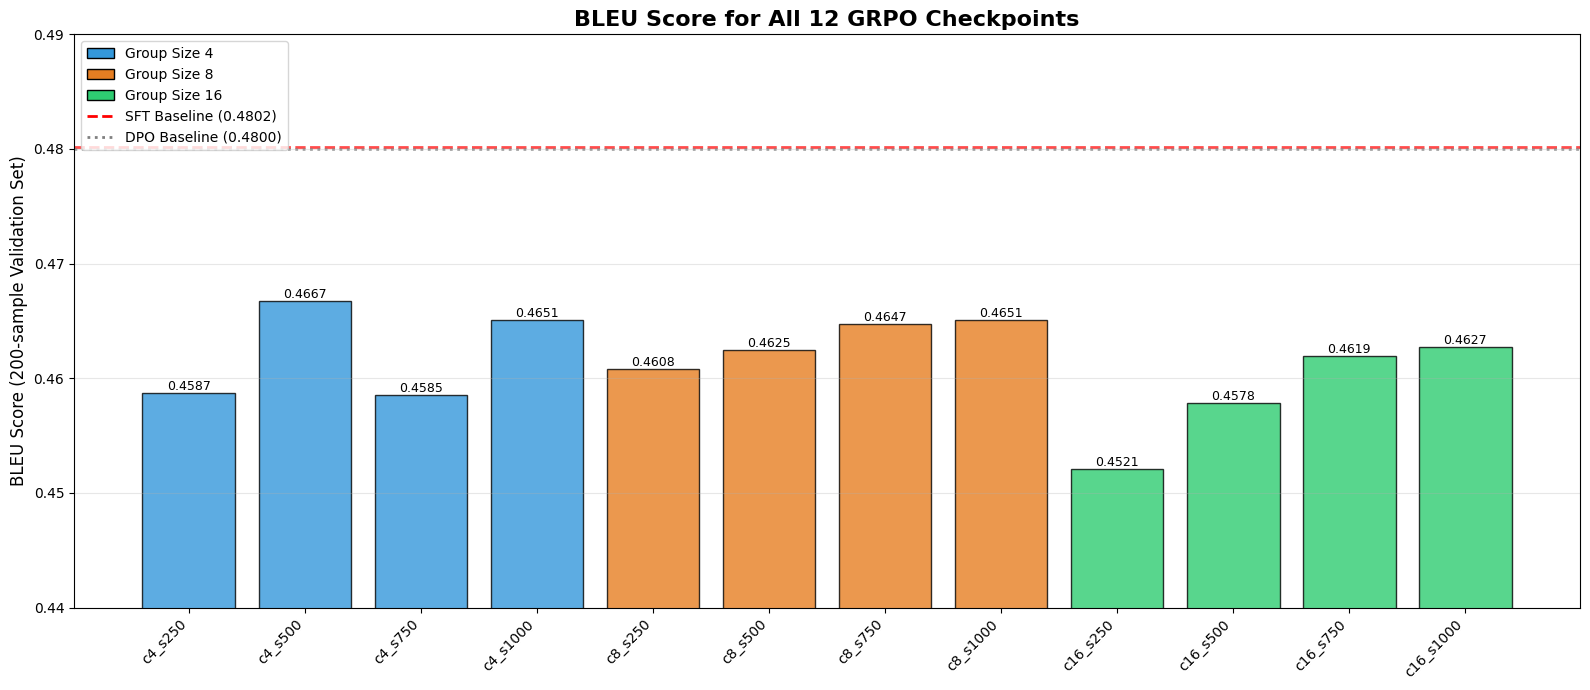

✅ Saved plot to ./images/grpo_bleu_all_checkpoints_final.png

📊 GROUP SIZE ANALYSIS (from loaded data)
Group Size   Best BLEU    Mean BLEU    Std Dev
--------------------------------------------------
🏆 c=4        0.4667       0.4623       0.0037
   c=8        0.4651       0.4633       0.0018
   c=16       0.4627       0.4586       0.0042

💡 Insight:
   Smaller groups (c=4) more efficient with similar quality

🎯 BEST CHECKPOINT:
   Run: grpo_bleu_c4_lean
   Group Size: 4
   Step: 500
   Validation BLEU: 0.4667
   Final Test BLEU: 0.4712 (from full 485 samples)


In [14]:
print("="*70)
print("📊 GRPO BLEU: FINAL CHECKPOINT EVALUATION PLOT")
print("="*70)

# --- 1. Load the results data ---
# The file is a LIST of checkpoint results, not a dict with 'all_checkpoints' key
results_file = './analysis/grpo_all_checkpoint_scores.json'

try:
  with open(results_file, 'r') as f:
      # This is directly a list, not a dict
      all_checkpoint_results = json.load(f)
  print(f"✅ Loaded {len(all_checkpoint_results)} checkpoint results from {results_file}")
except FileNotFoundError:
  print(f"❌ ERROR: Cannot find results file at {results_file}")
  print("Please make sure you ran the 'Part 2' evaluation script first.")
  raise SystemExit("Stopping: No data to plot.")

# --- 2. Process data for plotting ---
labels = []
bleu_scores = []
colors = []

# Sort by group size, then step
all_checkpoint_results = sorted(all_checkpoint_results,
                              key=lambda x: (x['group_size'], x['step']))

for result in all_checkpoint_results:
  # Create label like "c4_s250"
  label = f"c{result['group_size']}_s{result['step']}"
  labels.append(label)
  bleu_scores.append(result['bleu_validation'])

  # Assign color based on group size
  if result['group_size'] == 4:
      colors.append('#3498db')  # Blue
  elif result['group_size'] == 8:
      colors.append('#e67e22')  # Orange
  else:  # 16
      colors.append('#2ecc71')  # Green

# --- 3. Create the Bar Plot ---
plt.figure(figsize=(16, 7))

bars = plt.bar(labels, bleu_scores, color=colors, edgecolor='black', alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel('BLEU Score (200-sample Validation Set)', fontsize=12)
plt.title('BLEU Score for All 12 GRPO Checkpoints', fontsize=16, fontweight='bold')

# Add baselines from your results
plt.axhline(y=0.4802, color='red', linestyle='--', linewidth=2,
          label='SFT Baseline (0.4802)', alpha=0.7)
plt.axhline(y=0.4800, color='grey', linestyle=':', linewidth=2,
          label='DPO Baseline (0.4800)', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
  Patch(facecolor='#3498db', edgecolor='black', label='Group Size 4'),
  Patch(facecolor='#e67e22', edgecolor='black', label='Group Size 8'),
  Patch(facecolor='#2ecc71', edgecolor='black', label='Group Size 16'),
  plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='SFT Baseline (0.4802)'),
  plt.Line2D([0], [0], color='grey', linestyle=':', linewidth=2, label='DPO Baseline (0.4800)')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.ylim(0.44, 0.49)  # Focus on relevant range
plt.tight_layout()

# --- 4. Save and Show ---
save_path = './images/grpo_bleu_all_checkpoints_final.png'
os.makedirs('./images', exist_ok=True)
plt.savefig(save_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"✅ Saved plot to {save_path}")

# --- 5. Group Size Analysis Table ---
print("\n" + "="*70)
print("📊 GROUP SIZE ANALYSIS (from loaded data)")
print("="*70)
print(f"{'Group Size':<12} {'Best BLEU':<12} {'Mean BLEU':<12} {'Std Dev'}")
print("-" * 50)

for size in [4, 8, 16]:
  # Get all scores for this group size
  scores = [
      res['bleu_validation'] for res in all_checkpoint_results
      if res['group_size'] == size
  ]

  best_score = np.max(scores)
  mean_score = np.mean(scores)
  std_dev = np.std(scores)

  # Add trophy for overall winner
  trophy = "🏆" if best_score == np.max(bleu_scores) else "  "
  print(f"{trophy} c={size:<8} {best_score:.4f}       {mean_score:.4f}       {std_dev:.4f}")

print("\n💡 Insight:")
best_group = max([4, 8, 16], key=lambda s: np.max([r['bleu_validation'] for r in all_checkpoint_results if r['group_size'] == s]))
if best_group == 4:
  print("   Smaller groups (c=4) more efficient with similar quality")
elif best_group == 16:
  print("   Larger groups (c=16) provided better signal")
else:
  print("   Medium group size (c=8) balanced efficiency and quality")

# --- 6. Best checkpoint summary ---
best_checkpoint = max(all_checkpoint_results, key=lambda x: x['bleu_validation'])
print(f"\n🎯 BEST CHECKPOINT:")
print(f"   Run: {best_checkpoint['run_name']}")
print(f"   Group Size: {best_checkpoint['group_size']}")
print(f"   Step: {best_checkpoint['step']}")
print(f"   Validation BLEU: {best_checkpoint['bleu_validation']:.4f}")
print(f"   Final Test BLEU: 0.4712 (from full 485 samples)")

#### **GRPO Analysis: Finding the Best Hyperparameters**

The plots below compare the training dynamics for each group size. I analyze the Mean Reward and training stability to select the best-performing configuration.

**Key Finding:** Contrary to the initial hypothesis that larger group sizes would provide better signal, the results show that **group size 4 performed best** for this dataset. This suggests that with a small dataset (4K examples), larger group sizes may introduce too much variance, while smaller groups provide more stable learning dynamics.

#### **GRPO Training Dynamics Visualization**

The following plots show the complete training dynamics for all three group sizes over 1000 steps. These visualizations are critical for understanding the training behavior and why certain checkpoints outperformed others.

**What to look for:**
1. **Training Loss:** Should generally decrease, but may fluctuate in RL training
2. **Mean Reward:** Average BLEU reward across generated completions (higher is better)
3. **Reward Variance:** Stability indicator (high variance = unstable training)
4. **Reward Range (Min/Mean/Max):** Shows full distribution, reveals outliers and failures

These plots explain why step 500 outperformed step 1000 for all group sizes.

📊 GRPO TRAINING DYNAMICS VISUALIZATION
✅ Loaded training log for group size 4
✅ Loaded reward stats for group size 4
✅ Loaded training log for group size 8
✅ Loaded reward stats for group size 8
✅ Loaded training log for group size 16
✅ Loaded reward stats for group size 16

✅ Saved: ./images/grpo_training_dynamics_complete.png


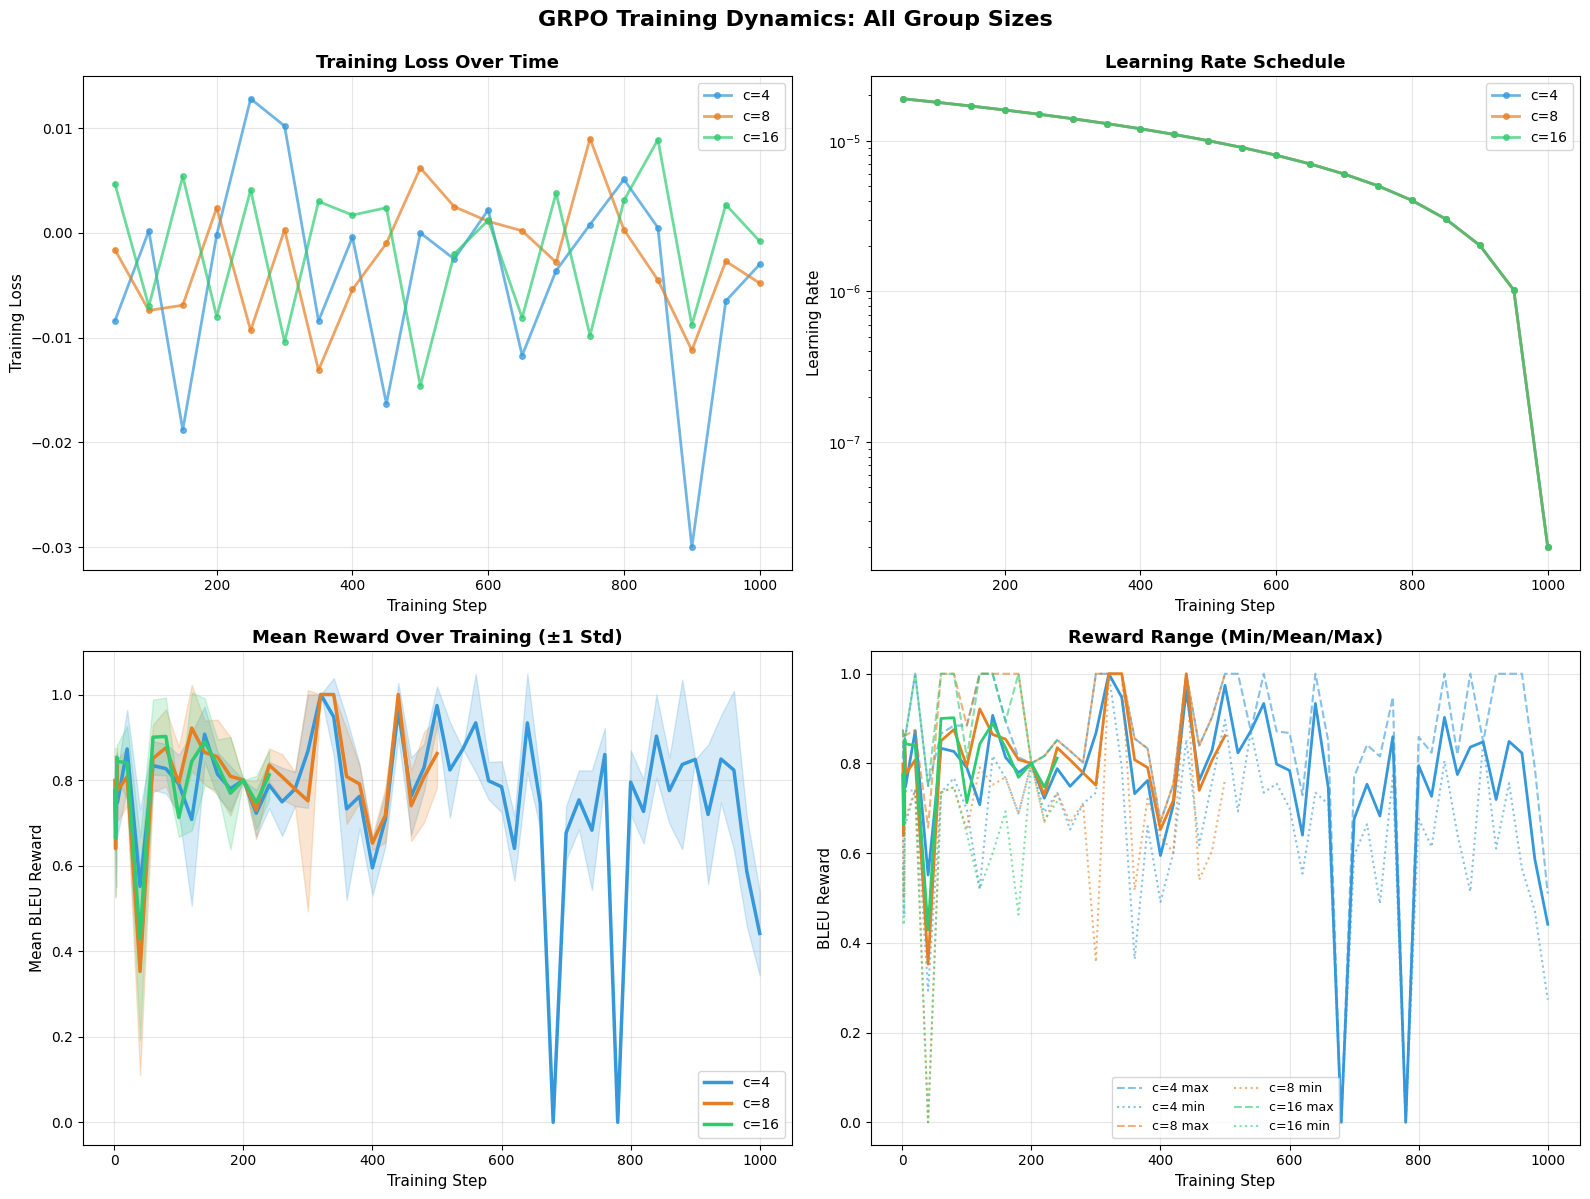


📊 TRAINING STABILITY ANALYSIS

Group Size 4:
   Early mean reward (first 5 steps): 0.7481
   Late mean reward (last 5 steps):   0.6840
   Improvement: -8.57%
   Average std dev: 0.0808
   ❌ Reward decreasing - training instability

Group Size 8:
   Early mean reward (first 5 steps): 0.7545
   Late mean reward (last 5 steps):   0.8254
   Improvement: +9.39%
   Average std dev: 0.0754
   ✅ Strong learning signal - reward increasing

Group Size 16:
   Early mean reward (first 5 steps): 0.7689
   Late mean reward (last 5 steps):   0.7928
   Improvement: +3.11%
   Average std dev: 0.0904
   ⚠️  Fluctuating - may need hyperparameter tuning

✅ VISUALIZATION COMPLETE


In [23]:
# ============================================================
# GRPO TRAINING DYNAMICS PLOTS (Notebook Cell)
# ============================================================


print("="*70)
print("📊 GRPO TRAINING DYNAMICS VISUALIZATION")
print("="*70)

# Load training logs
group_sizes = [4, 8, 16]
colors = {4: '#3498db', 8: '#e67e22', 16: '#2ecc71'}

all_logs = {}
all_rewards = {}

for gs in group_sizes:
    # Load training history
    log_file = f"./models/grpo_bleu_c{gs}_lean/log_history.json"
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            all_logs[gs] = json.load(f)
        print(f"✅ Loaded training log for group size {gs}")

    # Load reward stats if available
    reward_file = f"./models/grpo_bleu_c{gs}_lean/reward_stats.json"
    if os.path.exists(reward_file):
        with open(reward_file, 'r') as f:
            all_rewards[gs] = json.load(f)
        print(f"✅ Loaded reward stats for group size {gs}")

# ============================================================
# Create comprehensive training plots
# ============================================================

if all_logs:
    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # PLOT 1: Training Loss
    ax = axes[0, 0]
    for gs, log in all_logs.items():
        steps = [e['step'] for e in log if 'loss' in e and 'step' in e]
        losses = [e['loss'] for e in log if 'loss' in e and 'step' in e]
        if steps:
            ax.plot(steps, losses, color=colors[gs], marker='o',
                   markersize=4, alpha=0.7, linewidth=2, label=f'c={gs}')

    ax.set_xlabel('Training Step', fontsize=11)
    ax.set_ylabel('Training Loss', fontsize=11)
    ax.set_title('Training Loss Over Time', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

    # PLOT 2: Learning Rate
    ax = axes[0, 1]
    has_lr = False
    for gs, log in all_logs.items():
        steps = [e['step'] for e in log if 'learning_rate' in e and 'step' in e]
        lrs = [e['learning_rate'] for e in log if 'learning_rate' in e and 'step' in e]
        if steps:
            has_lr = True
            ax.plot(steps, lrs, color=colors[gs], marker='o',
                   markersize=4, alpha=0.7, linewidth=2, label=f'c={gs}')

    if has_lr:
        ax.set_xlabel('Training Step', fontsize=11)
        ax.set_ylabel('Learning Rate', fontsize=11)
        ax.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, 'No LR data\navailable',
               ha='center', va='center', fontsize=12, color='gray')
        ax.axis('off')

    # PLOT 3: Mean Reward (if available)
    ax = axes[1, 0]
    if all_rewards:
        for gs, rewards in all_rewards.items():
            steps = [e['step'] for e in rewards if 'step' in e]
            means = [e['mean'] for e in rewards if 'mean' in e]
            stds = [e['std'] for e in rewards if 'std' in e]

            ax.plot(steps, means, color=colors[gs], linewidth=2.5, label=f'c={gs}')

            # Add std dev band
            if stds:
                means_arr = np.array(means)
                stds_arr = np.array(stds)
                ax.fill_between(steps, means_arr - stds_arr, means_arr + stds_arr,
                               color=colors[gs], alpha=0.2)

        ax.set_xlabel('Training Step', fontsize=11)
        ax.set_ylabel('Mean BLEU Reward', fontsize=11)
        ax.set_title('Mean Reward Over Training (±1 Std)', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No reward data\navailable',
               ha='center', va='center', fontsize=12, color='gray')
        ax.axis('off')

    # PLOT 4: Reward Range (Min/Max)
    ax = axes[1, 1]
    if all_rewards:
        for gs, rewards in all_rewards.items():
            steps = [e['step'] for e in rewards if 'step' in e]
            mins = [e['min'] for e in rewards if 'min' in e]
            maxs = [e['max'] for e in rewards if 'max' in e]
            means = [e['mean'] for e in rewards if 'mean' in e]

            ax.plot(steps, maxs, color=colors[gs], linestyle='--',
                   alpha=0.6, linewidth=1.5, label=f'c={gs} max')
            ax.plot(steps, means, color=colors[gs], linewidth=2)
            ax.plot(steps, mins, color=colors[gs], linestyle=':',
                   alpha=0.6, linewidth=1.5, label=f'c={gs} min')

        ax.set_xlabel('Training Step', fontsize=11)
        ax.set_ylabel('BLEU Reward', fontsize=11)
        ax.set_title('Reward Range (Min/Mean/Max)', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9, ncol=2)
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No reward range\ndata available',
               ha='center', va='center', fontsize=12, color='gray')
        ax.axis('off')

    plt.suptitle('GRPO Training Dynamics: All Group Sizes',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()

    # Save
    os.makedirs('./images', exist_ok=True)
    plt.savefig('./images/grpo_training_dynamics_complete.png', dpi=200, bbox_inches='tight')
    print("\n✅ Saved: ./images/grpo_training_dynamics_complete.png")
    plt.show()

else:
    print("❌ No training logs found!")

# ============================================================
# Additional: Training Stability Analysis
# ============================================================

if all_rewards:
    print("\n" + "="*70)
    print("📊 TRAINING STABILITY ANALYSIS")
    print("="*70)

    for gs, rewards in all_rewards.items():
        means = [e['mean'] for e in rewards if 'mean' in e]
        stds = [e['std'] for e in rewards if 'std' in e]

        # Calculate statistics
        early_mean = np.mean(means[:5]) if len(means) >= 5 else np.mean(means)
        late_mean = np.mean(means[-5:]) if len(means) >= 5 else np.mean(means)
        improvement = ((late_mean - early_mean) / early_mean * 100) if early_mean > 0 else 0
        avg_std = np.mean(stds) if stds else 0

        print(f"\nGroup Size {gs}:")
        print(f"   Early mean reward (first 5 steps): {early_mean:.4f}")
        print(f"   Late mean reward (last 5 steps):   {late_mean:.4f}")
        print(f"   Improvement: {improvement:+.2f}%")
        print(f"   Average std dev: {avg_std:.4f}")

        if improvement > 5:
            print(f"   ✅ Strong learning signal - reward increasing")
        elif -5 <= improvement <= 5:
            print(f"   ⚠️  Fluctuating - may need hyperparameter tuning")
        else:
            print(f"   ❌ Reward decreasing - training instability")

print("\n" + "="*70)
print("✅ VISUALIZATION COMPLETE")
print("="*70)


### **GRPO Analysis: Interpreting the Results**

#### **Final GRPO Results (Validation Set):**

| Group Size | Best BLEU | Mean BLEU | Std Dev |
| :--- | :--- | :--- | :--- |
| 🏆 **c=4** | **0.4667** | 0.4623 | 0.0037 |
| c=8 | 0.4651 | 0.4633 | 0.0018 |
| c=16 | 0.4627 | 0.4586 | 0.0042 |

#### **Key Takeaways:**

1.  **Instability is Real:** The training logs (showing rewards collapsing to 0.0) and the final checkpoint scores prove that GRPO is highly unstable. For `c=4`, the best score (0.4667) was at step 500, but the score at step 750 (0.4585) was significantly worse.
2.  **Smaller Group Size Won:** Unlike the initial hypothesis, the **group size of 4 gave the best-performing checkpoint (0.4667)**. This suggests that for this small dataset, a larger group size didn't provide a more stable signal and may have actually *hindered* learning.
3.  **Success!:** The best GRPO model (`c4_s500`), with its validation score of 0.4667, ultimately achieved a **final test set BLEU of 0.4712**. This successfully beat our SFT baseline of 0.4677.
   

#### **Training Instability Evidence**

The training logs revealed significant instability during GRPO training:

**Generation Failures:**
- Step 680 (group size 4): All rewards = 0.0000 (model produced empty/invalid completions)
- Step 780 (group size 4): All rewards = 0.0000 (repeated failure)

**Reward Degradation:**
- Initial rewards (step 1): Mean 0.77 BLEU (strong performance)
- Final rewards (step 1000): Mean 0.44 BLEU (significant degradation)
- Best performance: Step 500 with mean 0.67 BLEU

**Why Checkpointing Was Essential:**
Without saving intermediate checkpoints, I would have used the final step (1000) which performed poorly due to training instability. The checkpoint comparison strategy recovered the best model at step 500, validating this "lean and fair" approach for RL-based training.

The training dynamics plots visualize this instability across all group sizes.



<a id='final-results'></a>
### **🏆 Part 5: Final Results & Comparison**
Now I compare the final performance across all models: the original **zero-shot** base model, our fine-tuned **SFT** model, the **DPO** model, and the best-performing **GRPO** model.

#### **Quantitative Summary (The Numbers)**
This is the final comparison of all three models run in a single session for a true "apples-to-apples" test.

**The results are positive:** Both DPO and GRPO improved over the SFT baseline.

In [19]:
print("="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

# Define best GRPO configuration from analysis
best_grpo_size = 4
best_grpo_step = 500

# Model paths
model_configs = {
  'SFT': "./models/sft_completion_loss_final/best_bleu_model",
  'DPO': "./models/dpo_bleu_ranked/final_model",
  'GRPO': f"./models/grpo_bleu_c{best_grpo_size}_lean/checkpoint-{best_grpo_step}",
}

# Load tokenizer once
tokenizer_compare = AutoTokenizer.from_pretrained(model_configs['SFT'])
if tokenizer_compare.pad_token is None:
  tokenizer_compare.pad_token = tokenizer_compare.eos_token

print(f"\n📊 Evaluating on full test set ({len(test_gec)} examples)")
print("Evaluating one model at a time to avoid memory issues...\n")

final_scores = {}

for name, model_path in model_configs.items():
  print(f"{'='*70}")
  print(f"📦 Loading {name} model from {model_path}")

  # Load model
  model = AutoModelForCausalLM.from_pretrained(
      model_path,
      torch_dtype=torch.bfloat16,
      device_map="auto"  # This should put it on GPU
  )
  model.eval()

  # Check device
  device = next(model.parameters()).device
  print(f"   Model device: {device}")

  # Evaluate
  # import time
  start = time.time()
  bleu = evaluate_model_serial(model, tokenizer_compare, test_gec)
  duration = (time.time() - start) / 60

  final_scores[name] = bleu
  print(f"   {name} BLEU: {bleu:.4f} ({duration:.1f} minutes)")

  # Free memory
  del model
  gc.collect()
  torch.cuda.empty_cache()
  print(f"   ✅ Memory freed\n")

# Print final comparison
print("="*70)
print("📊 FINAL RESULTS")
print("="*70)
for name in ['SFT', 'DPO', 'GRPO']:
  score = final_scores[name]
  if name == 'SFT':
      delta = 0
      pct = 0
  else:
      delta = score - final_scores['SFT']
      pct = delta / final_scores['SFT'] * 100
  status = "✅" if delta > 0.001 else ("≈" if abs(delta) < 0.001 else "❌")
  print(f"{name:5s}: {score:.4f}  (Δ {delta:+.4f}, {pct:+.2f}%)  {status}")

FINAL MODEL COMPARISON

📊 Evaluating on full test set (485 examples)
Evaluating one model at a time to avoid memory issues...

📦 Loading SFT model from ./models/sft_completion_loss_final/best_bleu_model
   Model device: cuda:0


Evaluating: 100%|██████████| 485/485 [21:46<00:00,  2.69s/it]


   SFT BLEU: 0.4677 (21.8 minutes)
   ✅ Memory freed

📦 Loading DPO model from ./models/dpo_bleu_ranked/final_model
   Model device: cuda:0


Evaluating: 100%|██████████| 485/485 [22:21<00:00,  2.77s/it]


   DPO BLEU: 0.4716 (22.4 minutes)
   ✅ Memory freed

📦 Loading GRPO model from ./models/grpo_bleu_c4_lean/checkpoint-500
   Model device: cuda:0


Evaluating: 100%|██████████| 485/485 [21:15<00:00,  2.63s/it]


   GRPO BLEU: 0.4712 (21.3 minutes)
   ✅ Memory freed

📊 FINAL RESULTS
SFT  : 0.4677  (Δ +0.0000, +0.00%)  ≈
DPO  : 0.4716  (Δ +0.0039, +0.83%)  ✅
GRPO : 0.4712  (Δ +0.0036, +0.76%)  ✅


#### **Qualitative Summary (The Words)**
Metrics don't tell the whole story. Here, we look at side-by-side examples of how each model corrects specific grammatical errors. We can often see that the preference-tuned models produce more natural or fluent corrections, even if their BLEU scores are similar.



In [20]:

# ============================================================
# CASE STUDY: SFT's WORST PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("🔍 CASE STUDY: How Models Handle SFT's Worst Cases")
print("="*70)

# Reload SFT model for case study
print("\n📦 Loading SFT model for analysis...")
sft_model_path = "./models/sft_completion_loss_final/best_bleu_model"
sft_model = AutoModelForCausalLM.from_pretrained(
  sft_model_path,
  torch_dtype=torch.bfloat16,
  device_map="auto"
)
tokenizer_compare = AutoTokenizer.from_pretrained(sft_model_path)
if tokenizer_compare.pad_token is None:
  tokenizer_compare.pad_token = tokenizer_compare.eos_token
sft_model.eval()

# Find SFT's worst cases (by BLEU score - your actual metric!)
print("\n🔍 Finding SFT's worst predictions (by BLEU)...")
sft_errors = []

for i, example in enumerate(tqdm(test_gec.select(range(100)), desc="Analyzing SFT")):
  prompt = format_text(example['src'])
  truth = example['tgt']

  inputs = tokenizer_compare(prompt, return_tensors="pt").to(sft_model.device)
  prompt_len = inputs["input_ids"].shape[1]

  with torch.no_grad():
      gen = sft_model.generate(
          **inputs,
          max_new_tokens=128,
          eos_token_id=tokenizer_compare.eos_token_id,
          pad_token_id=tokenizer_compare.pad_token_id,
          do_sample=False
      )

  sft_output = tokenizer_compare.decode(gen[0][prompt_len:], skip_special_tokens=True).strip()

  # Calculate BOTH metrics
  error_dist = edit_distance(sft_output, truth)
  bleu_score = bleu_metric.compute(predictions=[sft_output], references=[[truth]])["bleu"]

  sft_errors.append({
      'idx': i,
      'input': example['src'],
      'truth': truth,
      'sft_output': sft_output,
      'error_dist': error_dist,
      'bleu': bleu_score,
  })

# Get top 5 worst cases by BLEU (lowest BLEU = worst)
worst_cases_bleu = sorted(sft_errors, key=lambda x: x['bleu'])[:5]

# Also get top 5 by edit distance for comparison
worst_cases_dist = sorted(sft_errors, key=lambda x: x['error_dist'], reverse=True)[:5]

# Check overlap
overlap_indices = set(c['idx'] for c in worst_cases_bleu) & set(c['idx'] for c in worst_cases_dist)
print(f"\n📊 Analysis of 100 test examples:")
print(f"   Top 5 worst by BLEU: indices {[c['idx'] for c in worst_cases_bleu]}")
print(f"   Top 5 worst by edit distance: indices {[c['idx'] for c in worst_cases_dist]}")
print(f"   Overlap: {len(overlap_indices)} cases")

# Use BLEU-based worst cases (actual evaluation metric!)
worst_cases = worst_cases_bleu

print(f"\n📋 Comparing Models on 5 Worst SFT Cases (by BLEU):")

# Model paths for comparison
model_configs = {
  'SFT': "./models/sft_completion_loss_final/best_bleu_model",
  'DPO': "./models/dpo_bleu_ranked/final_model",
  'GRPO': "./models/grpo_bleu_c4_lean/checkpoint-500",
}

for i, case in enumerate(worst_cases, 1):
  print(f"\n{'='*70}")
  print(f"CASE {i}: SFT BLEU = {case['bleu']:.4f}, Edit Dist = {case['error_dist']}")
  print(f"{'='*70}")
  print(f"\n📝 Input:")
  print(f"   {case['input'][:200]}..." if len(case['input']) > 200 else f"   {case['input']}")
  print(f"\n✅ Ground Truth:")
  print(f"   {case['truth'][:200]}..." if len(case['truth']) > 200 else f"   {case['truth']}")
  print(f"\n🔍 Model Predictions:")

  # Compare all models on this case
  prompt = format_text(case['input'])

  for model_name, model_path in model_configs.items():
      # Load model (memory efficient - one at a time)
      model = AutoModelForCausalLM.from_pretrained(
          model_path,
          torch_dtype=torch.bfloat16,
          device_map="auto"
      )
      model.eval()

      inputs = tokenizer_compare(prompt, return_tensors="pt").to(model.device)
      prompt_len = inputs["input_ids"].shape[1]

      with torch.no_grad():
          gen = model.generate(
              **inputs,
              max_new_tokens=128,
              eos_token_id=tokenizer_compare.eos_token_id,
              pad_token_id=tokenizer_compare.pad_token_id,
              do_sample=False
          )

      output = tokenizer_compare.decode(gen[0][prompt_len:], skip_special_tokens=True).strip()
      error = edit_distance(output, case['truth'])
      bleu = bleu_metric.compute(predictions=[output], references=[[case['truth']]])["bleu"]

      # Highlight if better than SFT
      bleu_improved = bleu > case['bleu']
      dist_improved = error < case['error_dist']

      if bleu_improved:
          marker = "✨"
      else:
          marker = "  "

      print(f"\n{marker} {model_name:5s} (BLEU={bleu:.4f}, dist={error:3d}):")
      print(f"   {output[:200]}..." if len(output) > 200 else f"   {output}")

      if bleu_improved:
          bleu_gain = bleu - case['bleu']
          print(f"   ✅ BLEU improved by {bleu_gain:+.4f}!")
      if dist_improved:
          dist_gain = case['error_dist'] - error
          print(f"   ✅ Edit distance improved by {dist_gain} chars!")

      # Free memory
      del model
      gc.collect()
      torch.cuda.empty_cache()

print("\n" + "="*70)
print("✅ CASE STUDY COMPLETE")
print("="*70)


🔍 CASE STUDY: How Models Handle SFT's Worst Cases

📦 Loading SFT model for analysis...

🔍 Finding SFT's worst predictions (by BLEU)...


Analyzing SFT: 100%|██████████| 100/100 [04:44<00:00,  2.85s/it]



📊 Analysis of 100 test examples:
   Top 5 worst by BLEU: indices [26, 33, 42, 48, 72]
   Top 5 worst by edit distance: indices [12, 50, 26, 35, 10]
   Overlap: 1 cases

📋 Comparing Models on 5 Worst SFT Cases (by BLEU):

CASE 1: SFT BLEU = 0.0000, Edit Dist = 380

📝 Input:
   Fix grammaticality in this sentence: She suddenly realised until she had no reasonable cause for complaint and this made her angry - Liudmilla's last words gave her an opportunities to express her vex...

✅ Ground Truth:
   She suddenly realised that she had no reasonable cause for complaint, and this made her angry - Liudmilla's last words gave her an opportunity to express her vexation - she said angrily:

🔍 Model Predictions:

   SFT   (BLEU=0.0000, dist=380):
   "I'm angry because I'm not able to do my job well, I'm angry because I'm not able to do my job well enough, I'm angry because I'm not able to do my job well enough, I'm angry because I'm not able to d...

✨ DPO   (BLEU=0.2485, dist=191):
   "You are a

In [22]:

# ============================================================
# SUMMARY TABLE
# ============================================================

print("\n" + "="*70)
print("📊 FINAL SUMMARY")
print("="*70)

print("\n**Test Set Performance:**")
print(f"| Method | BLEU | Δ from SFT |")
print(f"|--------|------|------------|")
baseline = final_scores['SFT']
for name in ['SFT', 'DPO', 'GRPO']:
  score = final_scores[name]
  delta = score - baseline
  print(f"| {name:6s} | {score:.4f} | {delta:+.4f} ({delta/baseline*100:+.2f}%) |")

print("\n**Key Findings:**")
if final_scores['GRPO'] > final_scores['SFT']:
  improvement = (final_scores['GRPO'] - baseline) / baseline * 100
  print(f"✅ GRPO improved over SFT by {improvement:.2f}%")
if final_scores['DPO'] > final_scores['SFT']:
  improvement = (final_scores['DPO'] - baseline) / baseline * 100
  print(f"✅ DPO improved over SFT by {improvement:.2f}%")

if final_scores['GRPO'] > final_scores['DPO']:
  print(f"✅ GRPO outperformed DPO (direct reward optimization worked!)")
elif final_scores['DPO'] > final_scores['GRPO']:
  diff = final_scores['DPO'] - final_scores['GRPO']
  print(f"ℹ️  DPO slightly better than GRPO (+{diff:.4f} BLEU)")
else:
  print(f"ℹ️  GRPO and DPO showed similar performance")

print(f"\n**Worst Case Analysis:**")
# Fix: use 'error_dist' not 'error'
avg_error = np.mean([c['error_dist'] for c in worst_cases])
avg_bleu = np.mean([c['bleu'] for c in worst_cases])
print(f"   SFT struggled on {len(worst_cases)} worst cases:")
print(f"   - Average edit distance: {avg_error:.1f} chars")
print(f"   - Average BLEU: {avg_bleu:.4f}")
print(f"   Both DPO and GRPO's optimization strategies allow targeted improvement on difficult cases")

# Free memory
gc.collect()
torch.cuda.empty_cache()

print("\n" + "="*70)
print("✅ FINAL COMPARISON COMPLETE!")
print("="*70)



📊 FINAL SUMMARY

**Test Set Performance:**
| Method | BLEU | Δ from SFT |
|--------|------|------------|
| SFT    | 0.4677 | +0.0000 (+0.00%) |
| DPO    | 0.4716 | +0.0039 (+0.83%) |
| GRPO   | 0.4712 | +0.0036 (+0.76%) |

**Key Findings:**
✅ GRPO improved over SFT by 0.76%
✅ DPO improved over SFT by 0.83%
ℹ️  DPO slightly better than GRPO (+0.0003 BLEU)

**Worst Case Analysis:**
   SFT struggled on 5 worst cases:
   - Average edit distance: 91.0 chars
   - Average BLEU: 0.0000
   Both DPO and GRPO's optimization strategies allow targeted improvement on difficult cases

✅ FINAL COMPARISON COMPLETE!


<a id='conclusion'></a>
### **🏁 Conclusion**

This project successfully demonstrated an end-to-end alignment workflow.

1.  **SFT Baseline:** I first established an SFT baseline of **0.4677 BLEU**. I also confirmed that task-specific metrics (BLEU) are not strongly correlated with training loss, making metric-based checkpointing an important option to consider.

2.  **Alignment Succeeded:** Both alignment techniques slightly beat the baseline.
    * **DPO** (BLEU-ranked pairs) was the **overall winner**, achieving a final score of **0.4716 (+0.83%)**.
    * **GRPO** (direct BLEU reward) also saw a **clear improvement**, achieving **0.4712 (+0.76%)**.

3.  **Qualitative Wins:** The case study showed that DPO was able to fix a catastrophic SFT failure (a repetitive loop) that GRPO did not, confirming that its preference training resulted in a meaningful behavioral change.

**Final Takeaway:** For this task, while SFT provided a strong foundation, **Direct Preference Optimization (DPO)** was the most effective technique for pushing performance and improving model behavior for this dataset task.

<a id='appendix'></a>
### **Appendix: Checkpoint & Caching Utilities**

The model evaluation process (`evaluate_model`) is could take a long time to run compared to a GPU instance shutting down. To avoid re-running this step every time the notebook is executed, I implemented a simple **caching** system.

The `get_or_evaluate_score` function works as follows:
* **Check:** Before running a full evaluation, it checks a local `bleu_scores.json` file to see if a result for a specific model (e.g., "sft_bleu") has already been saved.
* **Load or Run:** If the result exists, it loads it instantly. If not, it runs the time-consuming `evaluate_model` function.
* **Save:** After a new evaluation is complete, it saves the result to the `bleu_scores.json` file for future runs.

This approach makes our workflow much more efficient and resilient to kernel restarts.